## Download the dataset files

In [ ]:
import os
import urllib.request
import tarfile
import scipy.io
import shutil

# Create a directory to store the dataset files
os.makedirs('flowers_data', exist_ok=True)

# Base URL and file names for downloading
base_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/"
files = {
    "images": "102flowers.tgz",  # File containing all the flower images
    "labels": "imagelabels.mat",  # File containing labels for the images
}

# Download each file
for name, filename in files.items():
    print(f"Downloading {filename}...")
    url = base_url + filename
    filepath = os.path.join('flowers_data', filename)
    urllib.request.urlretrieve(url, filepath)
    print(f"Saved to {filepath}")

# Extract the image files
print("Extracting images...")
with tarfile.open('flowers_data/102flowers.tgz', 'r:gz') as tar:
    tar.extractall(path='flowers_data')  # Extract images to the specified folder
print("Extraction complete!")

# Load the .mat file for labels
labels_path = 'flowers_data/imagelabels.mat'
labels = scipy.io.loadmat(labels_path)['labels'][0]  # Load flower category labels

# Organize images into folders based on their labels
os.makedirs('flowers_data/organized_data', exist_ok=True)
for idx, label in enumerate(labels):
    class_folder = os.path.join('flowers_data/organized_data', f"class_{label}")
    os.makedirs(class_folder, exist_ok=True)

    image_filename = f"image_{idx + 1:05d}.jpg"  # Maintain naming convention
    source_path = os.path.join('flowers_data/jpg', image_filename)
    destination_path = os.path.join(class_folder, image_filename)

    shutil.move(source_path, destination_path)
print(f"Organized images into {len(set(labels))} class folders.")

Saved to flowers_data/102flowers.tgz
Saved to flowers_data/imagelabels.mat
Extracting images...
Extraction complete!
Organized images into 102 class folders.


## Splitting the dataset

In [ ]:
import os
import shutil
import random

def split_dataset_with_seed(input_dir, output_dir, splits=2, train_ratio=0.5, val_ratio=0.25, seed=42):
    """
    Split dataset into multiple subsets with fixed test split and varying train/val splits.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Fix the test split across all splits
    random.seed(seed)  # Ensure reproducibility
    test_mapping = {}

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)

        random.shuffle(images)  # Shuffle once for test selection

        test_count = len(images) - int(train_ratio * len(images)) - int(val_ratio * len(images))
        test_mapping[class_name] = images[-test_count:]

    for split_num in range(splits):
        random.seed(seed + split_num)  # Use a different seed for train/val splits
        split_dir = os.path.join(output_dir, f"split_{split_num + 1}")
        os.makedirs(split_dir, exist_ok=True)
        for class_name in os.listdir(input_dir):
            class_path = os.path.join(input_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            images = os.listdir(class_path)

            # Exclude test images for train/val split
            remaining_images = [img for img in images if img not in test_mapping[class_name]]

            random.shuffle(remaining_images)

            train_count = int(train_ratio * len(images))
            val_count = int(val_ratio * len(images))

            split_mapping = {
                "train": remaining_images[:train_count],
                "val": remaining_images[train_count:train_count + val_count],
                "test": test_mapping[class_name]
            }

            for split_name, file_list in split_mapping.items():
                split_folder = os.path.join(split_dir, split_name, class_name)
                os.makedirs(split_folder, exist_ok=True)

                for file in file_list:
                    shutil.copy(os.path.join(class_path, file), os.path.join(split_folder, file))

    print(f"Dataset has been split into {splits} subsets with fixed test split and varying train/val splits.")

# Perform dataset splits with a fixed SEED
split_dataset_with_seed('flowers_data/organized_data', 'flowers_data/split_with_seed', splits=2, seed=42)


Dataset has been split into 2 subsets with fixed test split and varying train/val splits.


##  Common functions to both models (vgg19 + YOLOv5)

#### Create DataLoaders fonction

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Function to create DataLoaders for a specific split
def create_dataloaders_for_split(split_dir, batch_size=16):
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = ImageFolder(root=os.path.join(split_dir, 'train'), transform=transform_pipeline)
    val_data = ImageFolder(root=os.path.join(split_dir, 'val'), transform=transform_pipeline)
    test_data = ImageFolder(root=os.path.join(split_dir, 'test'), transform=transform_pipeline)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, len(train_data.classes)

#### Training and evaluation functions

In [ ]:
# Perform a single training epoch
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# General evaluation function (for validation and testing)
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

#### Train model function

In [ ]:
import torch
from torch import nn
import torch.optim as optim

# Main training and testing routine
def train_and_evaluate(model, train_loader, val_loader, test_loader, device, num_epochs=2, learning_rate=0.001, use_scheduler=False, hyperparameter_tuning=False):
    """
    Train and evaluate a model with an optional learning rate scheduler.

    Args:
        model: The model to train.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        test_loader: DataLoader for the testing dataset.
        device: Device to use for training ('cuda' or 'cpu').
        num_epochs: Number of epochs to train.
        learning_rate: Initial learning rate.
        use_scheduler: Boolean, whether to use a learning rate scheduler.

    Returns:
        train_losses, val_losses, train_accuracies, val_accuracies, test_losses, test_accuracies
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize scheduler if use_scheduler is True
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) if use_scheduler else None

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # Training phase
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if not hyperparameter_tuning:
          # Testing phase
          test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
          test_losses.append(test_loss)
          test_accuracies.append(test_accuracy)
          # Print epoch summary
          print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
                f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
        else:
          print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Step the scheduler if it is enabled
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_losses, test_accuracies


#### Creating and displaying graphs function

In [ ]:
import matplotlib.pyplot as plt

# Plot training results
def plot_results(history, title=None, without_test=False):
    %matplotlib inline
    epochs = range(1, len(history['train_losses']) + 1)

    # Setup a figure with two subplots (one for loss, one for accuracy)
    plt.figure(figsize=(14, 7))  # Adjusted figure size for better visibility

    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold')  # Add title above both subplots

    # Subplot 1: Loss Plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    if not without_test:
      plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Cross-Entropy Loss')

    # Subplot 2: Accuracy Plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    if not without_test:
      plt.plot(epochs, history['test_accuracy'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot params to make space for the title
    plt.show()

# VGG19 model

#### Create vgg19 model function

In [ ]:
import torch
from torch import nn
from torchvision import models

# Define VGG19 Model
def create_vgg19_model(num_classes, device):
    # Load pretrained VGG19 model
    vgg19 = models.vgg19(pretrained=True)

    # Freeze the pretrained layers
    for param in vgg19.features.parameters():
        param.requires_grad = False

    # Modify the classifier to match the number of classes
    vgg19.classifier = nn.Sequential(
        nn.Linear(vgg19.classifier[0].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

    # Move the model to the appropriate device
    vgg19.to(device)

    return vgg19

#### Hyperparameter Tuning


Learning rate: 0.0001, Batch size: 16

Processing 1...


/home/oranbe/.conda/envs/oran_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oranbe/.conda/envs/oran_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]
Train Loss: 3.0405, Train Acc: 0.3486, Val Loss: 1.6410, Val Acc: 0.6809
Epoch [2/10]
Train Loss: 1.0539, Train Acc: 0.7757, Val Loss: 1.0292, Val Acc: 0.7959
Epoch [3/10]
Train Loss: 0.4413, Train Acc: 0.9297, Val Loss: 0.8755, Val Acc: 0.8183
Epoch [4/10]
Train Loss: 0.2976, Train Acc: 0.9580, Val Loss: 0.7974, Val Acc: 0.8377
Epoch [5/10]
Train Loss: 0.2085, Train Acc: 0.9789, Val Loss: 0.7592, Val Acc: 0.8347
Epoch [6/10]
Train Loss: 0.1632, Train Acc: 0.9823, Val Loss: 0.7322, Val Acc: 0.8387
Epoch [7/10]
Train Loss: 0.1405, Train Acc: 0.9880, Val Loss: 0.7179, Val Acc: 0.8377
Epoch [8/10]
Train Loss: 0.1259, Train Acc: 0.9904, Val Loss: 0.7061, Val Acc: 0.8402
Epoch [9/10]
Train Loss: 0.1151, Train Acc: 0.9926, Val Loss: 0.7028, Val Acc: 0.8382
Epoch [10/10]
Train Loss: 0.1136, Train Acc: 0.9916, Val Loss: 0.6999, Val Acc: 0.8372

Processing 2...
Epoch [1/10]
Train Loss: 3.0297, Train Acc: 0.3572, Val Loss: 1.5830, Val Acc: 0.7148
Epoch [2/10]
Train Loss: 1.0158, Tra

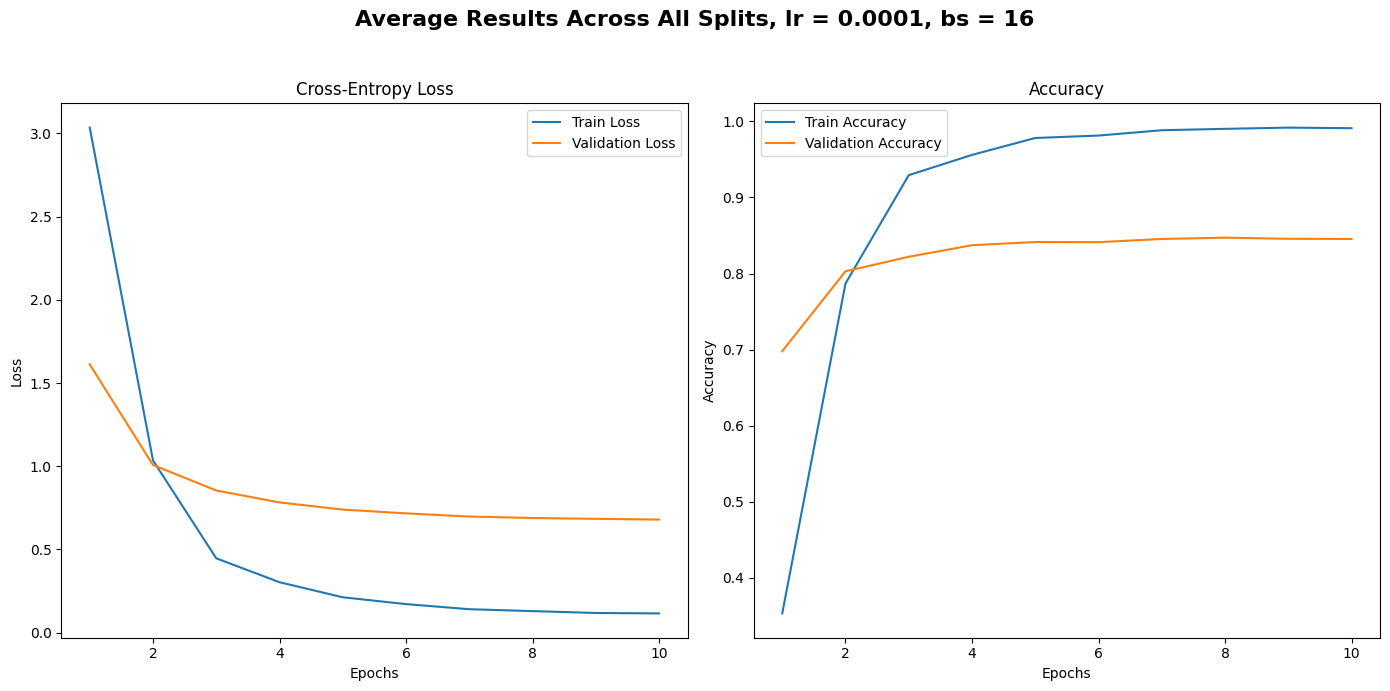

train losses: [3.03509486 1.0348731  0.44643197 0.30274242 0.21223946 0.17120783
 0.1404974  0.12905157 0.11779424 0.11509882], val losses: [1.61200461 1.00734176 0.8541001  0.7823097  0.73929033 0.71648533
 0.69747386 0.68868402 0.68370324 0.67930579], train acc: [0.3529484  0.78685504 0.92936118 0.95601966 0.97825553 0.98144963
 0.98845209 0.99029484 0.99189189 0.99115479], val acc: [0.69785963 0.80288701 0.82205077 0.83723245 0.84146341 0.84121453
 0.8454455  0.84718766 0.84569438 0.8454455 ]

Learning rate: 0.0001, Batch size: 32

Processing 1...
Epoch [1/10]
Train Loss: 3.2171, Train Acc: 0.3263, Val Loss: 1.8924, Val Acc: 0.6501
Epoch [2/10]
Train Loss: 1.2399, Train Acc: 0.7462, Val Loss: 1.2094, Val Acc: 0.7690
Epoch [3/10]
Train Loss: 0.5969, Train Acc: 0.9054, Val Loss: 1.0123, Val Acc: 0.8009
Epoch [4/10]
Train Loss: 0.4229, Train Acc: 0.9391, Val Loss: 0.9096, Val Acc: 0.8258
Epoch [5/10]
Train Loss: 0.2976, Train Acc: 0.9649, Val Loss: 0.8635, Val Acc: 0.8357
Epoch [6/10]


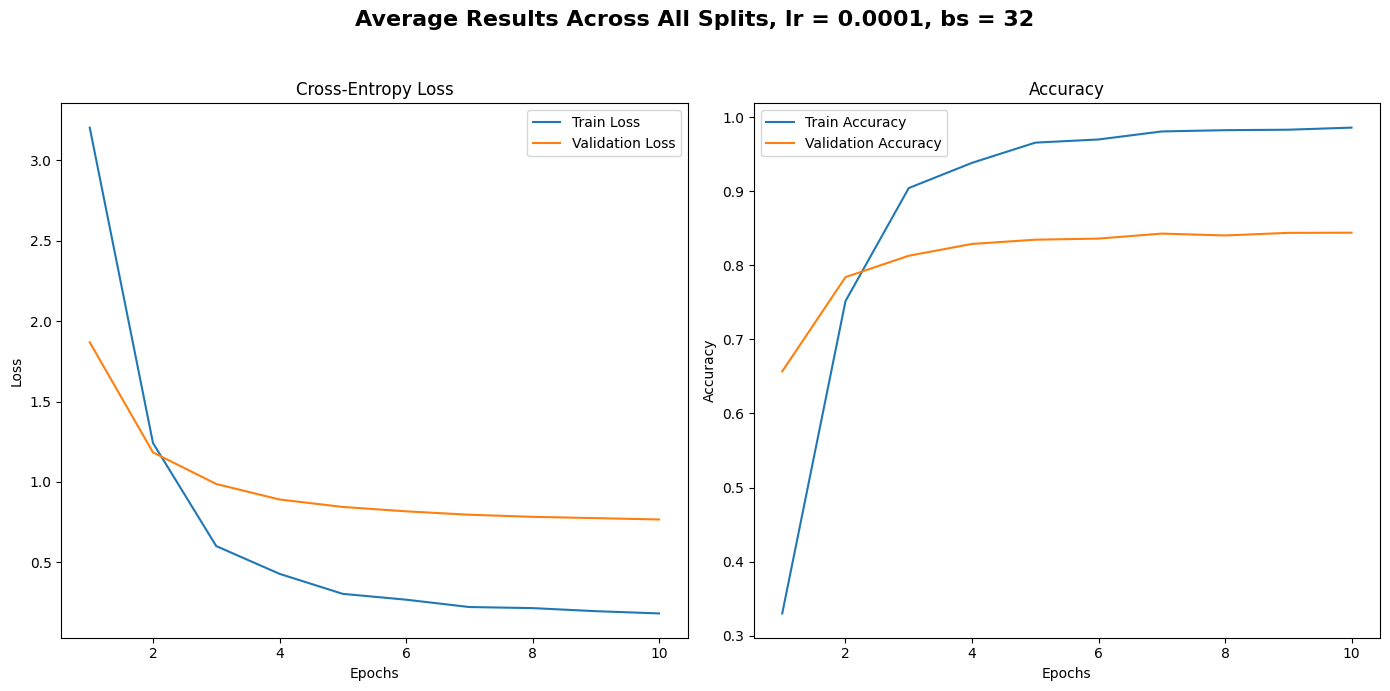

train losses: [3.20441876 1.24190808 0.60060752 0.42801788 0.30343059 0.26723225
 0.22147725 0.21473182 0.19563383 0.18162326], val losses: [1.86885247 1.18341705 0.98695499 0.89059052 0.84417558 0.81698233
 0.79573227 0.78267896 0.7746324  0.76619105], train acc: [0.33009828 0.75159705 0.9041769  0.93820639 0.96547912 0.96977887
 0.98058968 0.98230958 0.98292383 0.98574939], val acc: [0.65679443 0.78397213 0.81284221 0.82877053 0.83449477 0.83598805
 0.84270781 0.84021901 0.84370333 0.84395222]

Learning rate: 0.001, Batch size: 16

Processing 1...
Epoch [1/10]
Train Loss: 3.1769, Train Acc: 0.3057, Val Loss: 1.6365, Val Acc: 0.5983
Epoch [2/10]
Train Loss: 1.5194, Train Acc: 0.6025, Val Loss: 1.1508, Val Acc: 0.7103
Epoch [3/10]
Train Loss: 0.7696, Train Acc: 0.7885, Val Loss: 0.8290, Val Acc: 0.7735
Epoch [4/10]
Train Loss: 0.4698, Train Acc: 0.8631, Val Loss: 0.7699, Val Acc: 0.7964
Epoch [5/10]
Train Loss: 0.3113, Train Acc: 0.9108, Val Loss: 0.7169, Val Acc: 0.8044
Epoch [6/10]
T

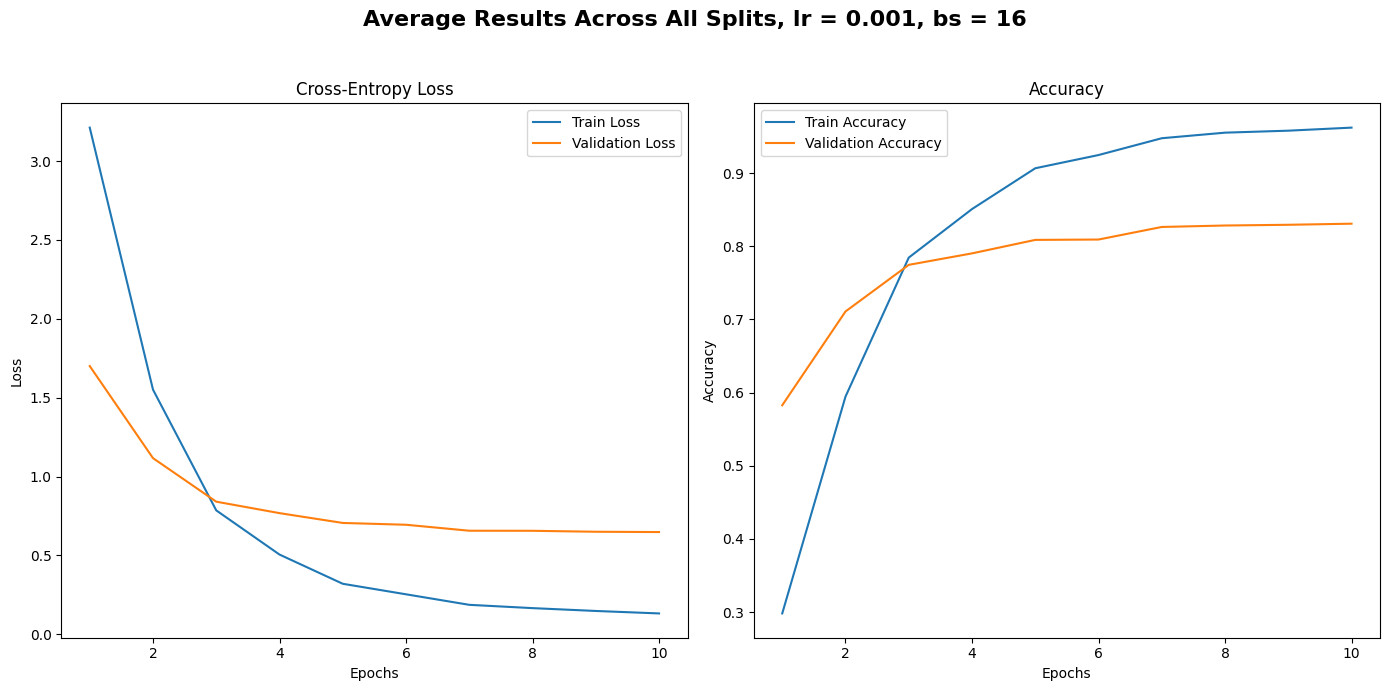

train losses: [3.21214607 1.55125371 0.7857858  0.50572095 0.32053982 0.25380991
 0.1871204  0.16619523 0.1482041  0.13255841], val losses: [1.70056713 1.11698562 0.84097112 0.76835683 0.70618349 0.69468008
 0.65686968 0.65637643 0.6503472  0.64838277], train acc: [0.29815725 0.59447174 0.78439803 0.8507371  0.90651106 0.92457002
 0.947543   0.95515971 0.95786241 0.96203931], val acc: [0.58262817 0.71080139 0.77451468 0.79019413 0.80861125 0.80910901
 0.82628173 0.82827277 0.82926829 0.83076157]

Learning rate: 0.001, Batch size: 32

Processing 1...
Epoch [1/10]
Train Loss: 2.8529, Train Acc: 0.3678, Val Loss: 1.3676, Val Acc: 0.6650
Epoch [2/10]
Train Loss: 0.9832, Train Acc: 0.7290, Val Loss: 0.9247, Val Acc: 0.7461
Epoch [3/10]
Train Loss: 0.4130, Train Acc: 0.8880, Val Loss: 0.7418, Val Acc: 0.8084
Epoch [4/10]
Train Loss: 0.2456, Train Acc: 0.9342, Val Loss: 0.6877, Val Acc: 0.8193
Epoch [5/10]
Train Loss: 0.1543, Train Acc: 0.9587, Val Loss: 0.6410, Val Acc: 0.8268
Epoch [6/10]
T

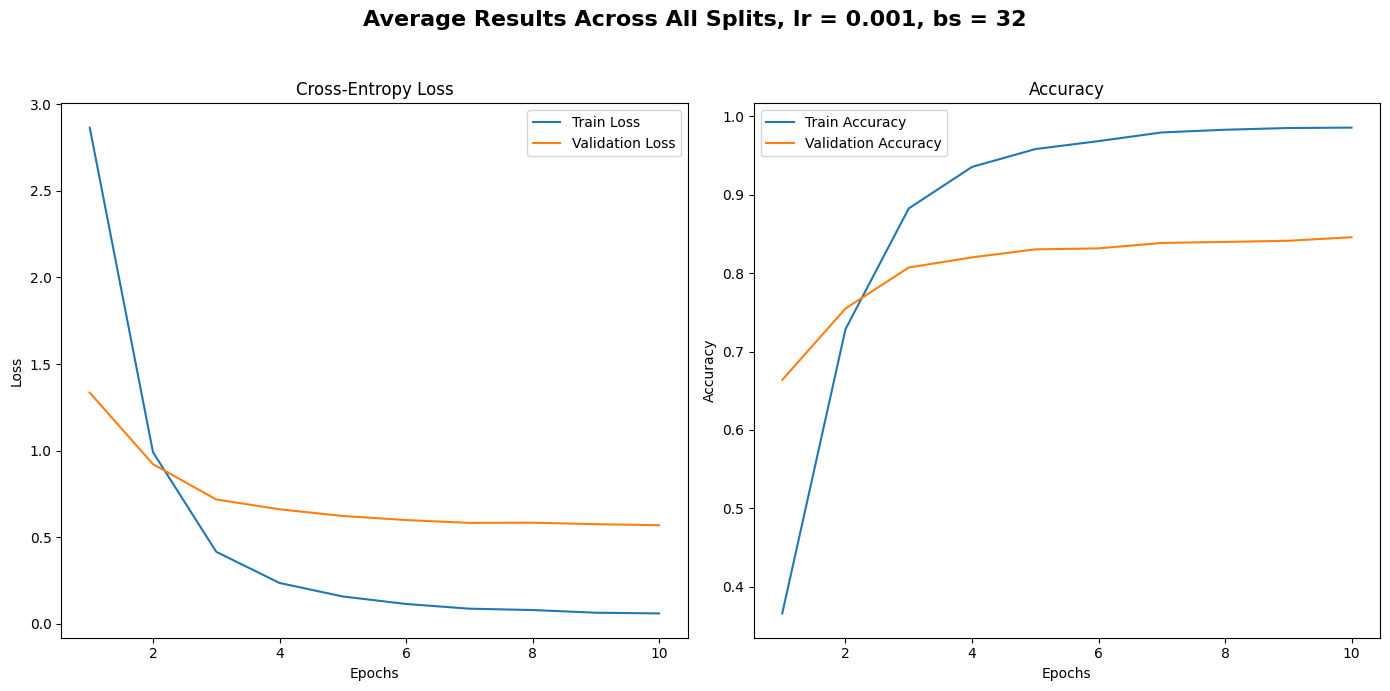

train losses: [2.86443675 0.99099583 0.4163281  0.2365715  0.15862138 0.11534052
 0.08817457 0.08033012 0.06488984 0.06072663], val losses: [1.33482526 0.92214299 0.71846455 0.66168969 0.62323382 0.59964887
 0.58338575 0.58457456 0.57583647 0.56978056], train acc: [0.36597052 0.72850123 0.88243243 0.93538084 0.95810811 0.96830467
 0.97936118 0.98280098 0.98501229 0.98550369], val acc: [0.66376307 0.75485316 0.80711797 0.82005973 0.83026381 0.83150821
 0.83847685 0.83972125 0.84121453 0.84569438]

Learning rate: 0.01, Batch size: 16

Processing 1...
Epoch [1/10]
Train Loss: 6.8463, Train Acc: 0.0550, Val Loss: 4.3989, Val Acc: 0.0612
Epoch [2/10]
Train Loss: 4.6295, Train Acc: 0.0555, Val Loss: 4.4443, Val Acc: 0.0592
Epoch [3/10]
Train Loss: 4.7883, Train Acc: 0.0494, Val Loss: 4.4719, Val Acc: 0.0478
Epoch [4/10]
Train Loss: 4.6776, Train Acc: 0.0514, Val Loss: 4.4291, Val Acc: 0.0473
Epoch [5/10]
Train Loss: 4.5129, Train Acc: 0.0572, Val Loss: 4.3812, Val Acc: 0.0577
Epoch [6/10]
Tr

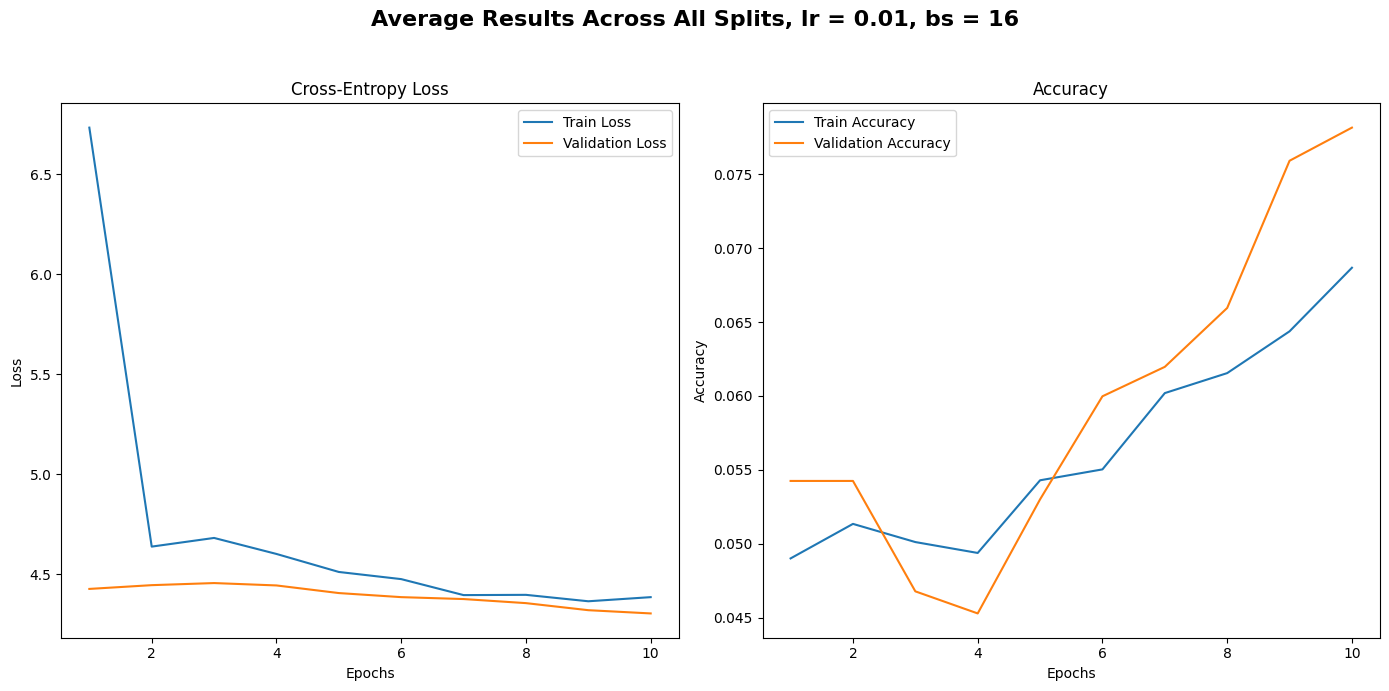

train losses: [6.73411143 4.63921422 4.68256368 4.60251957 4.5124511  4.47670297
 4.39675403 4.39804166 4.36591476 4.38651427], val losses: [4.42767166 4.446473   4.4569412  4.44505856 4.40692366 4.38656629
 4.3769965  4.35661096 4.32130629 4.30510744], train acc: [0.0490172  0.05135135 0.05012285 0.04938575 0.05429975 0.05503686
 0.06019656 0.06154791 0.06437346 0.06867322], val acc: [0.05425585 0.05425585 0.04678945 0.04529617 0.05301145 0.05998009
 0.06197113 0.06595321 0.07590841 0.07814833]

Learning rate: 0.01, Batch size: 32

Processing 1...
Epoch [1/10]
Train Loss: 7.7030, Train Acc: 0.0491, Val Loss: 5.2510, Val Acc: 0.0453
Epoch [2/10]
Train Loss: 4.5292, Train Acc: 0.0698, Val Loss: 4.4224, Val Acc: 0.0742
Epoch [3/10]
Train Loss: 4.5619, Train Acc: 0.0759, Val Loss: 4.3394, Val Acc: 0.0781
Epoch [4/10]
Train Loss: 4.4579, Train Acc: 0.0774, Val Loss: 4.2742, Val Acc: 0.0931
Epoch [5/10]
Train Loss: 4.3409, Train Acc: 0.0882, Val Loss: 4.2504, Val Acc: 0.0986
Epoch [6/10]
Tr

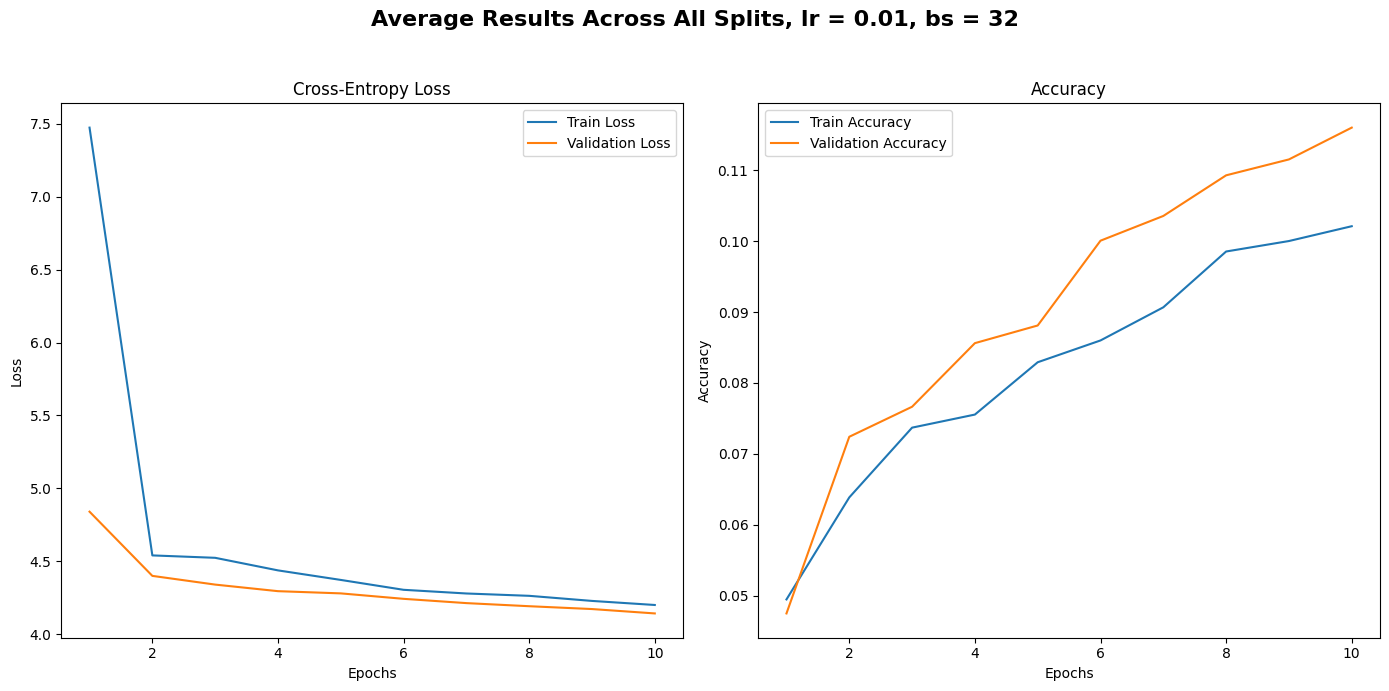

train losses: [7.47391758 4.54049572 4.52400721 4.43779784 4.37237183 4.30459986
 4.27936016 4.26332938 4.2283883  4.20051544], val losses: [4.84032317 4.4000918  4.34033863 4.29524334 4.28007856 4.24271505
 4.21333958 4.19205719 4.17261402 4.14258503], train acc: [0.0495086  0.06388206 0.07371007 0.07555283 0.08292383 0.08599509
 0.09066339 0.0985258  0.1        0.10208845], val acc: [0.04753609 0.07242409 0.07665505 0.08561473 0.08810353 0.10004978
 0.1035341  0.10925834 0.11149826 0.1159781 ]


In [ ]:
import os
import torch
import numpy as np

# Parameters
split_base_dir = 'flowers_data/split_with_seed'
num_classes = 102  # Based on the Oxford Flowers 102 dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate_set = [0.0001, 0.001,0.01]
batch_size_set = [16, 32]

for lr in learning_rate_set:
    for bs in batch_size_set:
        print(f"\nLearning rate: {lr}, Batch size: {bs}")

        # Storage for all splits
        all_train_losses = []
        all_val_losses = []
        all_train_accuracies = []
        all_val_accuracies = []
        all_test_losses = []
        all_test_accuracies = []

        # Iterate over dataset splits and train models
        splits = os.listdir(split_base_dir)
        for i, split_name in enumerate(splits):
            print(f"\nProcessing {i +1}...")
            split_dir = os.path.join(split_base_dir, split_name)

            # Create DataLoaders for this split
            train_loader, val_loader, test_loader, num_classes = create_dataloaders_for_split(split_dir, batch_size=bs)

            # Create and train the model
            vgg19_model = create_vgg19_model(num_classes=num_classes, device=device)
            train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
                model=vgg19_model,
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_epochs=num_epochs,
                learning_rate=lr,
                use_scheduler=True,
                hyperparameter_tuning=True
            )

            # Store results
            all_train_losses.append(train_losses)
            all_val_losses.append(val_losses)
            all_train_accuracies.append(train_accuracies)
            all_val_accuracies.append(val_accuracies)
            all_test_losses.append(test_loss)
            all_test_accuracies.append(test_accuracy)

        # Calculate average results across splits
        average_train_losses = np.mean(all_train_losses, axis=0)
        average_val_losses = np.mean(all_val_losses, axis=0)
        average_train_accuracies = np.mean(all_train_accuracies, axis=0)
        average_val_accuracies = np.mean(all_val_accuracies, axis=0)
        average_test_loss = np.mean(all_test_losses, axis=0)
        average_test_accuracy = np.mean(all_test_accuracies, axis=0)

        # Plot average results
        plot_results({
            'train_losses': average_train_losses,
            'val_losses': average_val_losses,
            'test_loss': average_test_loss,
            'train_accuracies': average_train_accuracies,
            'val_accuracies': average_val_accuracies,
            'test_accuracy': average_test_accuracy
        }, title="Average Results Across All Splits, lr = " + str(lr) + ", bs = " + str(bs), without_test=True)

        print("train losses: " + str(average_train_losses) + ", val losses: " + str(average_val_losses) + ", train acc: " + str(average_train_accuracies) + ", val acc: " + str(average_val_accuracies))

#### Run train


Processing 1...
Epoch [1/10]
Train Loss: 3.2265, Train Acc: 0.3084, Val Loss: 1.9165, Val Acc: 0.6252, Test Loss: 1.8934, Test Acc: 0.6294
Epoch [2/10]
Train Loss: 1.2628, Train Acc: 0.7425, Val Loss: 1.2055, Val Acc: 0.7725, Test Loss: 1.1808, Test Acc: 0.7739
Epoch [3/10]
Train Loss: 0.6061, Train Acc: 0.9005, Val Loss: 1.0209, Val Acc: 0.7909, Test Loss: 0.9913, Test Acc: 0.7981
Epoch [4/10]
Train Loss: 0.4229, Train Acc: 0.9430, Val Loss: 0.9198, Val Acc: 0.8173, Test Loss: 0.8952, Test Acc: 0.8232
Epoch [5/10]
Train Loss: 0.3200, Train Acc: 0.9631, Val Loss: 0.8766, Val Acc: 0.8278, Test Loss: 0.8499, Test Acc: 0.8346
Epoch [6/10]
Train Loss: 0.2676, Train Acc: 0.9713, Val Loss: 0.8456, Val Acc: 0.8313, Test Loss: 0.8147, Test Acc: 0.8384
Epoch [7/10]
Train Loss: 0.2253, Train Acc: 0.9818, Val Loss: 0.8261, Val Acc: 0.8318, Test Loss: 0.7978, Test Acc: 0.8408
Epoch [8/10]
Train Loss: 0.2050, Train Acc: 0.9821, Val Loss: 0.8108, Val Acc: 0.8357, Test Loss: 0.7829, Test Acc: 0.8417

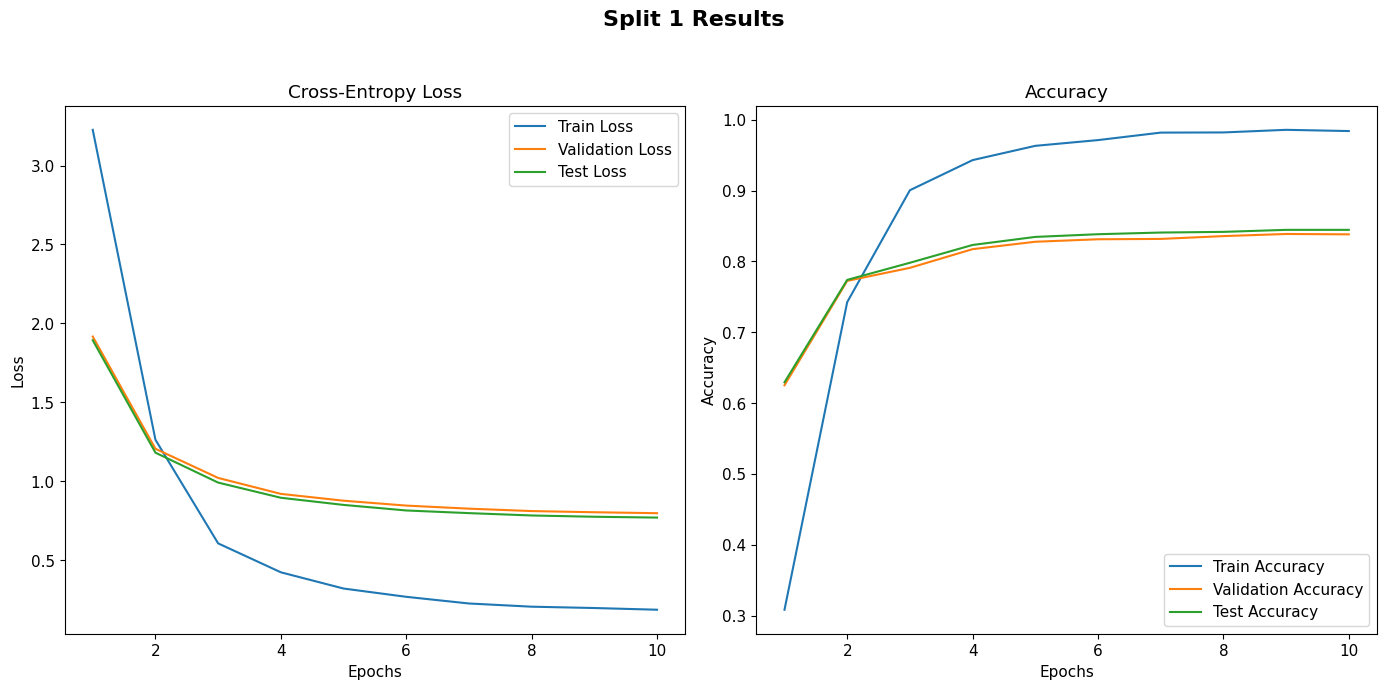

Model saved to vgg19_flower_model_split_1.pth

Processing 2...
Epoch [1/10]
Train Loss: 3.2610, Train Acc: 0.3076, Val Loss: 1.9282, Val Acc: 0.6257, Test Loss: 1.9227, Test Acc: 0.6270
Epoch [2/10]
Train Loss: 1.3085, Train Acc: 0.7270, Val Loss: 1.1808, Val Acc: 0.7725, Test Loss: 1.1770, Test Acc: 0.7777
Epoch [3/10]
Train Loss: 0.6223, Train Acc: 0.8953, Val Loss: 0.9731, Val Acc: 0.8173, Test Loss: 0.9729, Test Acc: 0.8166
Epoch [4/10]
Train Loss: 0.4439, Train Acc: 0.9324, Val Loss: 0.8703, Val Acc: 0.8357, Test Loss: 0.8692, Test Acc: 0.8341
Epoch [5/10]
Train Loss: 0.3112, Train Acc: 0.9636, Val Loss: 0.8253, Val Acc: 0.8347, Test Loss: 0.8275, Test Acc: 0.8370
Epoch [6/10]
Train Loss: 0.2653, Train Acc: 0.9735, Val Loss: 0.7900, Val Acc: 0.8392, Test Loss: 0.7887, Test Acc: 0.8441
Epoch [7/10]
Train Loss: 0.2204, Train Acc: 0.9811, Val Loss: 0.7694, Val Acc: 0.8392, Test Loss: 0.7713, Test Acc: 0.8502
Epoch [8/10]
Train Loss: 0.2081, Train Acc: 0.9823, Val Loss: 0.7549, Val Ac

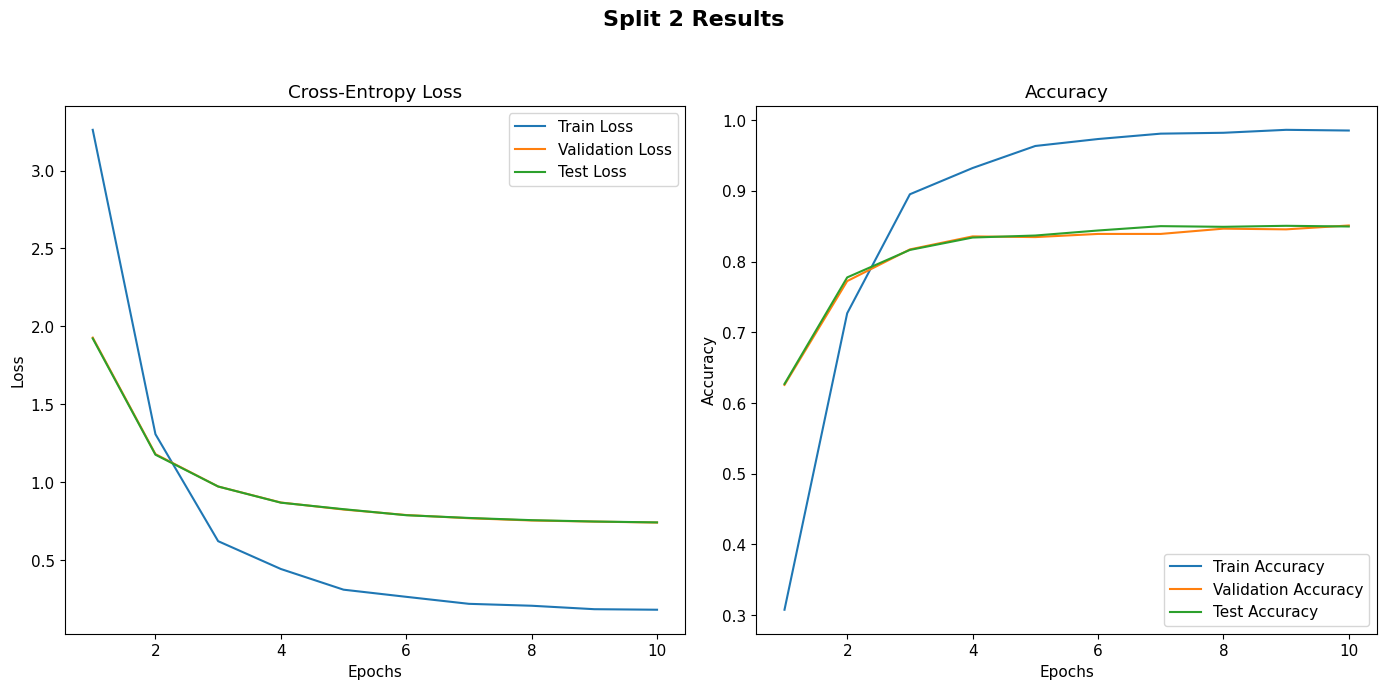

Model saved to vgg19_flower_model_split_2.pth


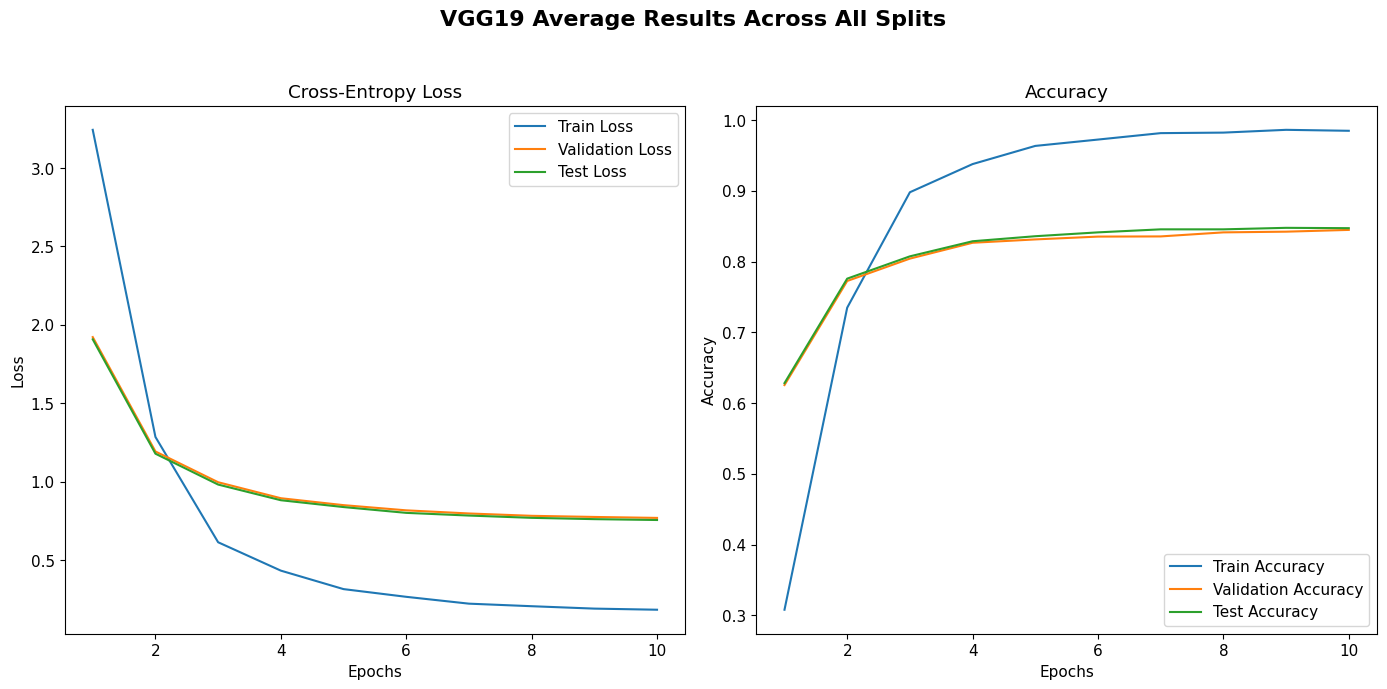

In [ ]:
import os
import torch
import numpy as np

# Parameters
split_base_dir = 'flowers_data/split_with_seed'
num_classes = 102  # Based on the Oxford Flowers 102 dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.0001
batch_size = 32

# Storage for all splits
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_losses = []
all_test_accuracies = []

# Iterate over dataset splits and train models
splits = os.listdir(split_base_dir)
for i, split_name in enumerate(splits):
    print(f"\nProcessing {i +1}...")
    split_dir = os.path.join(split_base_dir, split_name)

    # Create DataLoaders for this split
    train_loader, val_loader, test_loader, num_classes = create_dataloaders_for_split(split_dir, batch_size)

    # Create and train the model
    vgg19_model = create_vgg19_model(num_classes=num_classes, device=device)
    train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
        model=vgg19_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        use_scheduler=True
    )

    # Store results
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)

    # Plot and save results
    plot_results({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy
    }, title=f"Split {i + 1} Results")

    # Save the trained model
    model_path = f"vgg19_flower_model_split_{i + 1}.pth"
    torch.save(vgg19_model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Calculate average results across splits
average_train_losses = np.mean(all_train_losses, axis=0)
average_val_losses = np.mean(all_val_losses, axis=0)
average_train_accuracies = np.mean(all_train_accuracies, axis=0)
average_val_accuracies = np.mean(all_val_accuracies, axis=0)
average_test_loss = np.mean(all_test_losses, axis=0)
average_test_accuracy = np.mean(all_test_accuracies, axis=0)

# Plot average results
plot_results({
    'train_losses': average_train_losses,
    'val_losses': average_val_losses,
    'test_loss': average_test_loss,
    'train_accuracies': average_train_accuracies,
    'val_accuracies': average_val_accuracies,
    'test_accuracy': average_test_accuracy
}, title="VGG19 Average Results Across All Splits")


# YOLOv5 model

#### Import the model from Git

In [ ]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

# Install dependencies
!pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


#### Create TOLOV5 model function

In [ ]:
import torch
from torch import nn
import sys
sys.path.append('yolov5')
from yolov5.models.common import DetectMultiBackend
from yolov5.models.experimental import attempt_load

# Load YOLOv5 model and modify it for classification
def load_and_modify_yolov5(model_path, num_classes, device, freeze_layers=True):
    # Load the model using DetectMultiBackend
    model_backend = DetectMultiBackend(model_path, device=device, dnn=False, data=None, fp16=False)

    # Load the PyTorch model
    model_pt = attempt_load(model_path, device=device)

    # Freeze layers if required
    if freeze_layers:
        for param in model_pt.model[:-1].parameters():  # Freeze all layers except the last one
            param.requires_grad = False

    # Modify the final classification layer
    in_features = model_pt.model[-1].linear.in_features
    model_pt.model[-1].linear = nn.Linear(in_features, num_classes).to(device)

    return model_pt.to(device)


#### Hyperparameter Tuning


Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9135, Train Acc: 0.6506, Val Loss: 0.8394, Val Acc: 0.8537, Test Loss: 0.8319, Test Acc: 0.8659
Epoch [2/10]
Train Loss: 0.4644, Train Acc: 0.9400, Val Loss: 0.5567, Val Acc: 0.8910, Test Loss: 0.5397, Test Acc: 0.8915
Epoch [3/10]
Train Loss: 0.2489, Train Acc: 0.9764, Val Loss: 0.4839, Val Acc: 0.9039, Test Loss: 0.4713, Test Acc: 0.9019
Epoch [4/10]
Train Loss: 0.1923, Train Acc: 0.9853, Val Loss: 0.4405, Val Acc: 0.9109, Test Loss: 0.4192, Test Acc: 0.9133
Epoch [5/10]
Train Loss: 0.1490, Train Acc: 0.9921, Val Loss: 0.4188, Val Acc: 0.9154, Test Loss: 0.4001, Test Acc: 0.9185
Epoch [6/10]
Train Loss: 0.1316, Train Acc: 0.9936, Val Loss: 0.4036, Val Acc: 0.9134, Test Loss: 0.3849, Test Acc: 0.9213
Epoch [7/10]
Train Loss: 0.1155, Train Acc: 0.9963, Val Loss: 0.3957, Val Acc: 0.9149, Test Loss: 0.3766, Test Acc: 0.9190
Epoch [8/10]
Train Loss: 0.1083, Train Acc: 0.9966, Val Loss: 0.3889, Val Acc: 0.9169, Test Loss: 0.3690, Test Acc: 0.9204
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.8999, Train Acc: 0.6585, Val Loss: 0.8092, Val Acc: 0.8626, Test Loss: 0.8243, Test Acc: 0.8602
Epoch [2/10]
Train Loss: 0.4738, Train Acc: 0.9327, Val Loss: 0.5329, Val Acc: 0.9034, Test Loss: 0.5492, Test Acc: 0.8953
Epoch [3/10]
Train Loss: 0.2580, Train Acc: 0.9776, Val Loss: 0.4439, Val Acc: 0.9169, Test Loss: 0.4569, Test Acc: 0.9180
Epoch [4/10]
Train Loss: 0.1977, Train Acc: 0.9850, Val Loss: 0.4030, Val Acc: 0.9238, Test Loss: 0.4140, Test Acc: 0.9209
Epoch [5/10]
Train Loss: 0.1542, Train Acc: 0.9912, Val Loss: 0.3816, Val Acc: 0.9248, Test Loss: 0.3916, Test Acc: 0.9242
Epoch [6/10]
Train Loss: 0.1366, Train Acc: 0.9926, Val Loss: 0.3697, Val Acc: 0.9258, Test Loss: 0.3797, Test Acc: 0.9232
Epoch [7/10]
Train Loss: 0.1205, Train Acc: 0.9953, Val Loss: 0.3607, Val Acc: 0.9258, Test Loss: 0.3709, Test Acc: 0.9237
Epoch [8/10]
Train Loss: 0.1128, Train Acc: 0.9956, Val Loss: 0.3542, Val Acc: 0.9278, Test Loss: 0.3650, Test Acc: 0.9275
Epoch [9/10]
Tra

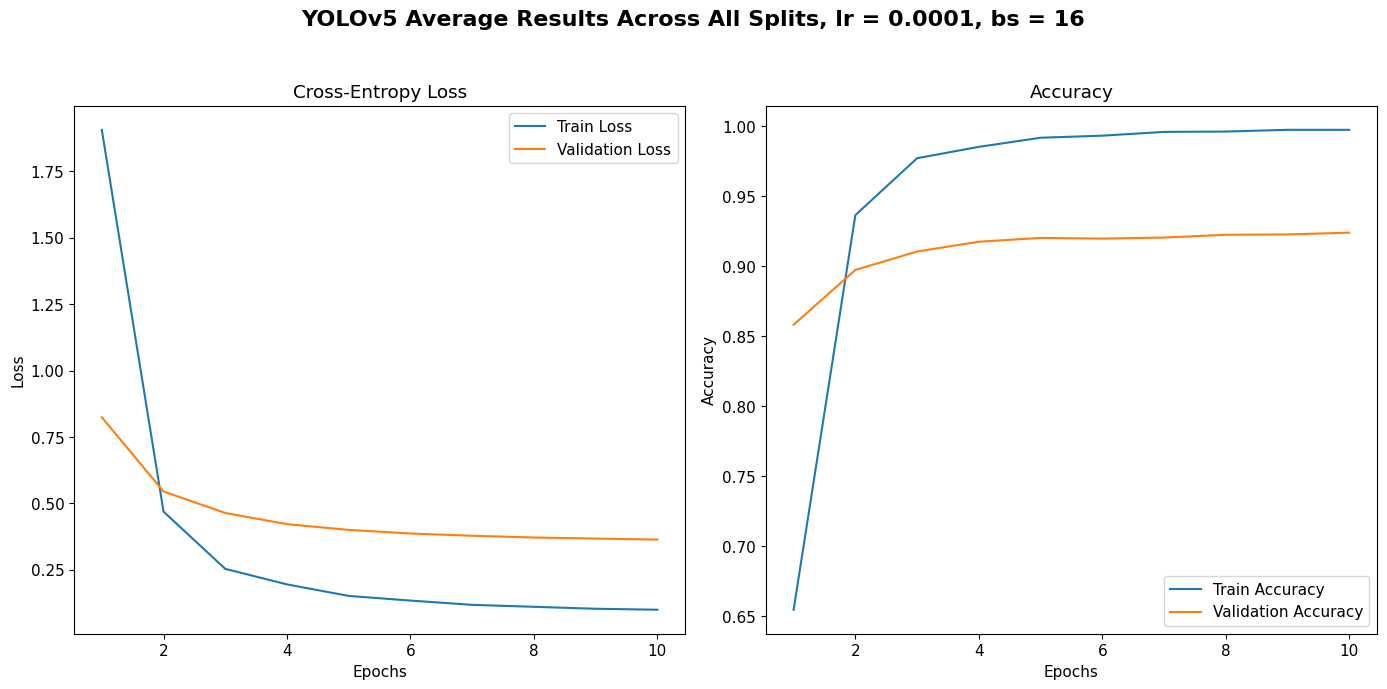

train losses: [     1.9067     0.46908     0.25349     0.19498      0.1516     0.13408     0.11797     0.11058     0.10328    0.099608], val losses: [    0.82426      0.5448     0.46393     0.42176     0.40021     0.38662     0.37817     0.37153     0.36759     0.36374], train acc: [    0.65455     0.93636     0.97703     0.98514     0.99165     0.99312     0.99582     0.99607      0.9973      0.9973], val acc: [    0.85814     0.89721      0.9104     0.91737     0.92011     0.91961     0.92036     0.92235      0.9226     0.92384]

Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3070, Train Acc: 0.5730, Val Loss: 1.1350, Val Acc: 0.8188, Test Loss: 1.1223, Test Acc: 0.8171
Epoch [2/10]
Train Loss: 0.6719, Train Acc: 0.9143, Val Loss: 0.6894, Val Acc: 0.8835, Test Loss: 0.6803, Test Acc: 0.8782
Epoch [3/10]
Train Loss: 0.3868, Train Acc: 0.9619, Val Loss: 0.5980, Val Acc: 0.8910, Test Loss: 0.5797, Test Acc: 0.8953
Epoch [4/10]
Train Loss: 0.3028, Train Acc: 0.9752, Val Loss: 0.5354, Val Acc: 0.8975, Test Loss: 0.5178, Test Acc: 0.9033
Epoch [5/10]
Train Loss: 0.2472, Train Acc: 0.9813, Val Loss: 0.5084, Val Acc: 0.9064, Test Loss: 0.4910, Test Acc: 0.9076
Epoch [6/10]
Train Loss: 0.2219, Train Acc: 0.9850, Val Loss: 0.4878, Val Acc: 0.9094, Test Loss: 0.4701, Test Acc: 0.9085
Epoch [7/10]
Train Loss: 0.2006, Train Acc: 0.9880, Val Loss: 0.4761, Val Acc: 0.9114, Test Loss: 0.4584, Test Acc: 0.9109
Epoch [8/10]
Train Loss: 0.1899, Train Acc: 0.9892, Val Loss: 0.4667, Val Acc: 0.9129, Test Loss: 0.4484, Test Acc: 0.9104
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3141, Train Acc: 0.5705, Val Loss: 1.0935, Val Acc: 0.8422, Test Loss: 1.1098, Test Acc: 0.8341
Epoch [2/10]
Train Loss: 0.6840, Train Acc: 0.9118, Val Loss: 0.6572, Val Acc: 0.8930, Test Loss: 0.6759, Test Acc: 0.8896
Epoch [3/10]
Train Loss: 0.3998, Train Acc: 0.9609, Val Loss: 0.5579, Val Acc: 0.9129, Test Loss: 0.5722, Test Acc: 0.9085
Epoch [4/10]
Train Loss: 0.3148, Train Acc: 0.9695, Val Loss: 0.4960, Val Acc: 0.9139, Test Loss: 0.5095, Test Acc: 0.9180
Epoch [5/10]
Train Loss: 0.2566, Train Acc: 0.9813, Val Loss: 0.4694, Val Acc: 0.9169, Test Loss: 0.4817, Test Acc: 0.9194
Epoch [6/10]
Train Loss: 0.2303, Train Acc: 0.9843, Val Loss: 0.4506, Val Acc: 0.9174, Test Loss: 0.4625, Test Acc: 0.9166
Epoch [7/10]
Train Loss: 0.2089, Train Acc: 0.9867, Val Loss: 0.4398, Val Acc: 0.9189, Test Loss: 0.4520, Test Acc: 0.9204
Epoch [8/10]
Train Loss: 0.1982, Train Acc: 0.9880, Val Loss: 0.4310, Val Acc: 0.9199, Test Loss: 0.4429, Test Acc: 0.9166
Epoch [9/10]
Tra

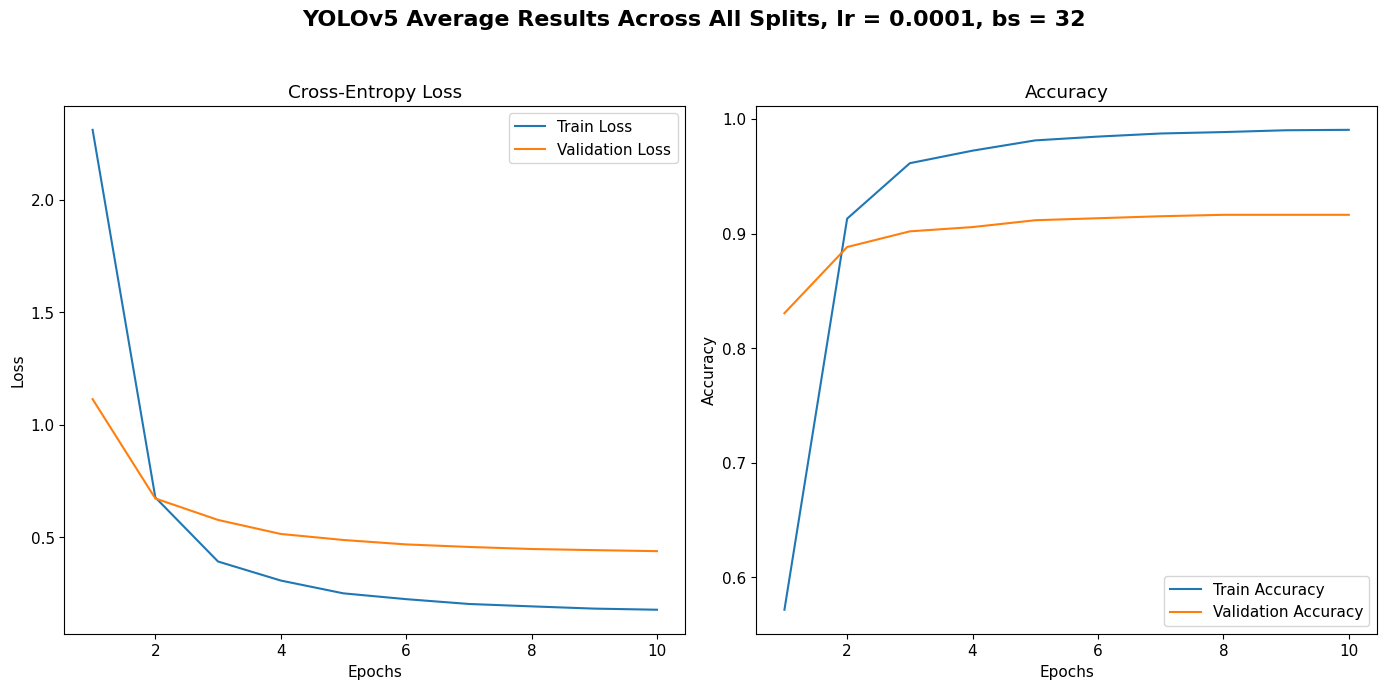

train losses: [     2.3106     0.67791     0.39329      0.3088     0.25189     0.22612     0.20472     0.19406      0.1841     0.17916], val losses: [     1.1142      0.6733     0.57794     0.51569     0.48889     0.46921     0.45795     0.44887     0.44387     0.43929], train acc: [    0.57174     0.91302     0.96143     0.97236     0.98133     0.98464     0.98735     0.98857     0.99017     0.99054], val acc: [    0.83051     0.88825     0.90194     0.90567     0.91165     0.91339     0.91513     0.91638     0.91638     0.91638]

Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.8987, Train Acc: 0.6440, Val Loss: 0.8499, Val Acc: 0.8522, Test Loss: 0.8291, Test Acc: 0.8526
Epoch [2/10]
Train Loss: 0.4609, Train Acc: 0.9398, Val Loss: 0.5612, Val Acc: 0.8860, Test Loss: 0.5363, Test Acc: 0.8934
Epoch [3/10]
Train Loss: 0.2488, Train Acc: 0.9774, Val Loss: 0.4803, Val Acc: 0.9044, Test Loss: 0.4598, Test Acc: 0.9109
Epoch [4/10]
Train Loss: 0.1889, Train Acc: 0.9862, Val Loss: 0.4444, Val Acc: 0.9129, Test Loss: 0.4190, Test Acc: 0.9133
Epoch [5/10]
Train Loss: 0.1475, Train Acc: 0.9931, Val Loss: 0.4210, Val Acc: 0.9164, Test Loss: 0.3938, Test Acc: 0.9209
Epoch [6/10]
Train Loss: 0.1294, Train Acc: 0.9934, Val Loss: 0.4087, Val Acc: 0.9139, Test Loss: 0.3821, Test Acc: 0.9218
Epoch [7/10]
Train Loss: 0.1142, Train Acc: 0.9968, Val Loss: 0.3980, Val Acc: 0.9139, Test Loss: 0.3723, Test Acc: 0.9246
Epoch [8/10]
Train Loss: 0.1071, Train Acc: 0.9975, Val Loss: 0.3914, Val Acc: 0.9189, Test Loss: 0.3659, Test Acc: 0.9209
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9151, Train Acc: 0.6339, Val Loss: 0.8377, Val Acc: 0.8462, Test Loss: 0.8552, Test Acc: 0.8502
Epoch [2/10]
Train Loss: 0.4762, Train Acc: 0.9337, Val Loss: 0.5224, Val Acc: 0.8950, Test Loss: 0.5348, Test Acc: 0.9057
Epoch [3/10]
Train Loss: 0.2586, Train Acc: 0.9769, Val Loss: 0.4461, Val Acc: 0.9144, Test Loss: 0.4605, Test Acc: 0.9190
Epoch [4/10]
Train Loss: 0.1981, Train Acc: 0.9845, Val Loss: 0.4015, Val Acc: 0.9233, Test Loss: 0.4144, Test Acc: 0.9213
Epoch [5/10]
Train Loss: 0.1554, Train Acc: 0.9912, Val Loss: 0.3831, Val Acc: 0.9223, Test Loss: 0.3960, Test Acc: 0.9237
Epoch [6/10]
Train Loss: 0.1373, Train Acc: 0.9919, Val Loss: 0.3684, Val Acc: 0.9228, Test Loss: 0.3795, Test Acc: 0.9270
Epoch [7/10]
Train Loss: 0.1213, Train Acc: 0.9946, Val Loss: 0.3610, Val Acc: 0.9223, Test Loss: 0.3718, Test Acc: 0.9280
Epoch [8/10]
Train Loss: 0.1136, Train Acc: 0.9958, Val Loss: 0.3533, Val Acc: 0.9253, Test Loss: 0.3645, Test Acc: 0.9275
Epoch [9/10]
Tra

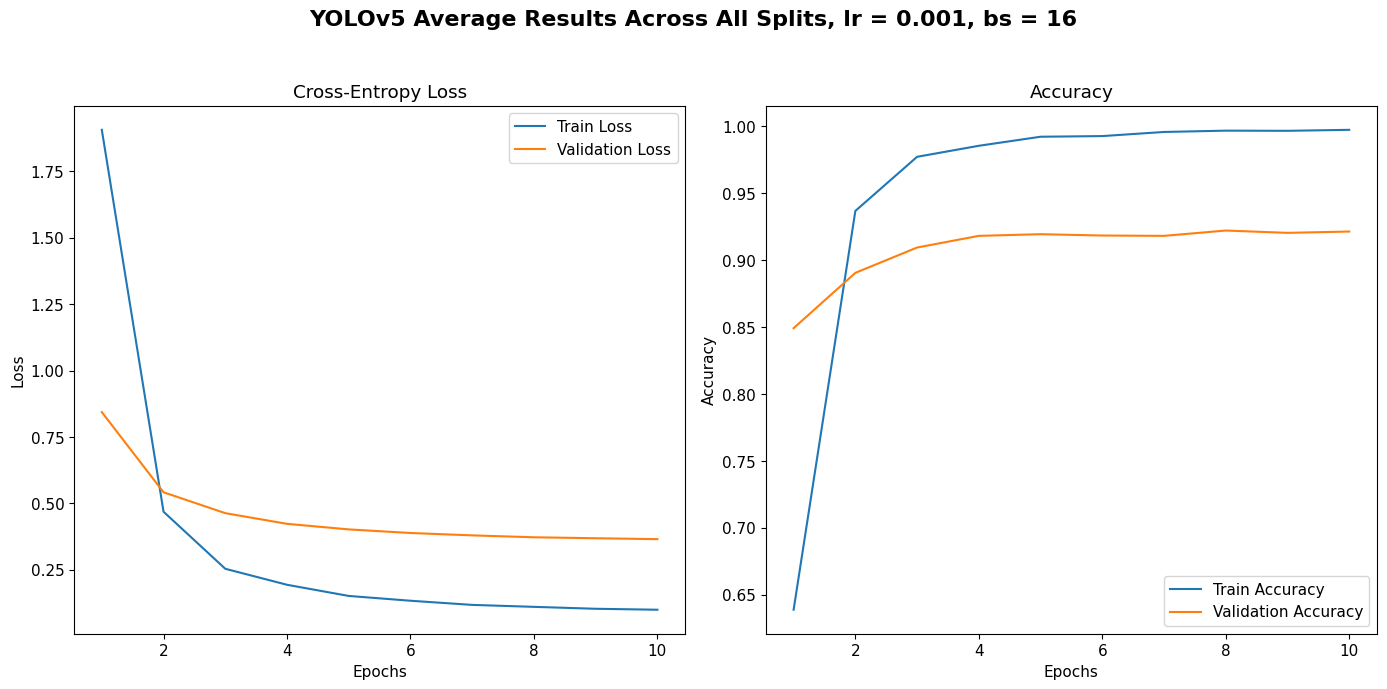

train losses: [     1.9069     0.46857     0.25373      0.1935     0.15145     0.13335     0.11771     0.11035     0.10311    0.099517], val losses: [     0.8438     0.54182      0.4632     0.42298     0.40205     0.38852     0.37952     0.37237     0.36871     0.36536], train acc: [    0.63894     0.93673     0.97715     0.98538     0.99214     0.99263      0.9957     0.99668     0.99656      0.9973], val acc: [    0.84918     0.89049     0.90941     0.91812     0.91936     0.91837     0.91812      0.9221     0.92036     0.92135]

Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3068, Train Acc: 0.5683, Val Loss: 1.1267, Val Acc: 0.8268, Test Loss: 1.1158, Test Acc: 0.8346
Epoch [2/10]
Train Loss: 0.6724, Train Acc: 0.9177, Val Loss: 0.7033, Val Acc: 0.8805, Test Loss: 0.6844, Test Acc: 0.8806
Epoch [3/10]
Train Loss: 0.3884, Train Acc: 0.9651, Val Loss: 0.5936, Val Acc: 0.8980, Test Loss: 0.5799, Test Acc: 0.8953
Epoch [4/10]
Train Loss: 0.3034, Train Acc: 0.9769, Val Loss: 0.5385, Val Acc: 0.8975, Test Loss: 0.5205, Test Acc: 0.9066
Epoch [5/10]
Train Loss: 0.2483, Train Acc: 0.9821, Val Loss: 0.5093, Val Acc: 0.9054, Test Loss: 0.4911, Test Acc: 0.9066
Epoch [6/10]
Train Loss: 0.2222, Train Acc: 0.9855, Val Loss: 0.4882, Val Acc: 0.9074, Test Loss: 0.4695, Test Acc: 0.9114
Epoch [7/10]
Train Loss: 0.2013, Train Acc: 0.9880, Val Loss: 0.4771, Val Acc: 0.9084, Test Loss: 0.4588, Test Acc: 0.9147
Epoch [8/10]
Train Loss: 0.1905, Train Acc: 0.9889, Val Loss: 0.4677, Val Acc: 0.9104, Test Loss: 0.4489, Test Acc: 0.9152
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3228, Train Acc: 0.5715, Val Loss: 1.1022, Val Acc: 0.8138, Test Loss: 1.1097, Test Acc: 0.8161
Epoch [2/10]
Train Loss: 0.6931, Train Acc: 0.9074, Val Loss: 0.6517, Val Acc: 0.8950, Test Loss: 0.6655, Test Acc: 0.8919
Epoch [3/10]
Train Loss: 0.4010, Train Acc: 0.9587, Val Loss: 0.5564, Val Acc: 0.9144, Test Loss: 0.5696, Test Acc: 0.9081
Epoch [4/10]
Train Loss: 0.3155, Train Acc: 0.9735, Val Loss: 0.4984, Val Acc: 0.9139, Test Loss: 0.5131, Test Acc: 0.9118
Epoch [5/10]
Train Loss: 0.2584, Train Acc: 0.9806, Val Loss: 0.4719, Val Acc: 0.9164, Test Loss: 0.4845, Test Acc: 0.9175
Epoch [6/10]
Train Loss: 0.2323, Train Acc: 0.9835, Val Loss: 0.4528, Val Acc: 0.9169, Test Loss: 0.4643, Test Acc: 0.9180
Epoch [7/10]
Train Loss: 0.2108, Train Acc: 0.9880, Val Loss: 0.4412, Val Acc: 0.9199, Test Loss: 0.4527, Test Acc: 0.9209
Epoch [8/10]
Train Loss: 0.1999, Train Acc: 0.9889, Val Loss: 0.4314, Val Acc: 0.9199, Test Loss: 0.4423, Test Acc: 0.9209
Epoch [9/10]
Tra

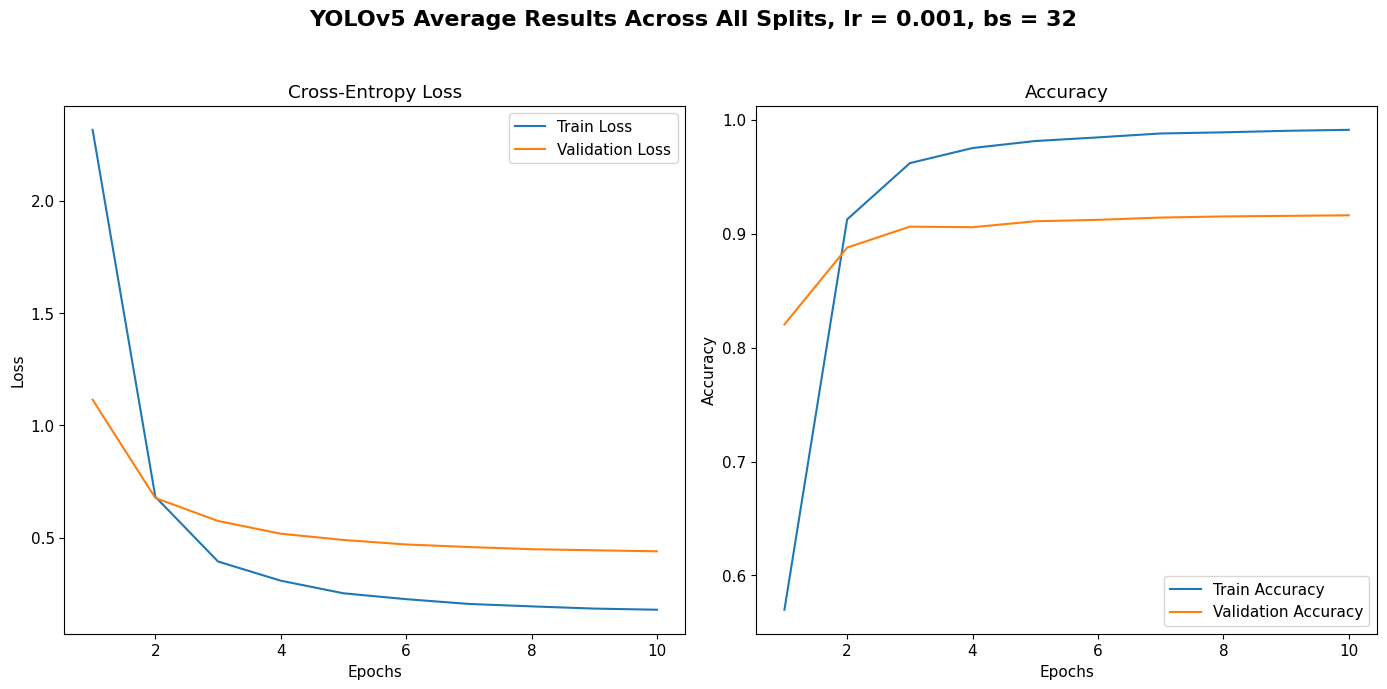

train losses: [     2.3148     0.68274     0.39469     0.30949     0.25339     0.22728     0.20602     0.19519     0.18532     0.18027], val losses: [     1.1145      0.6775       0.575     0.51849     0.49061     0.47051     0.45913     0.44957     0.44469      0.4401], train acc: [     0.5699     0.91253     0.96192     0.97518     0.98133     0.98452     0.98796     0.98894     0.99029     0.99115], val acc: [    0.82031     0.88776     0.90617     0.90567      0.9109     0.91215     0.91414     0.91513     0.91563     0.91613]

Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9068, Train Acc: 0.6423, Val Loss: 0.8437, Val Acc: 0.8646, Test Loss: 0.8361, Test Acc: 0.8588
Epoch [2/10]
Train Loss: 0.4622, Train Acc: 0.9403, Val Loss: 0.5565, Val Acc: 0.8895, Test Loss: 0.5394, Test Acc: 0.8967
Epoch [3/10]
Train Loss: 0.2479, Train Acc: 0.9771, Val Loss: 0.4834, Val Acc: 0.9034, Test Loss: 0.4641, Test Acc: 0.9043
Epoch [4/10]
Train Loss: 0.1880, Train Acc: 0.9867, Val Loss: 0.4423, Val Acc: 0.9089, Test Loss: 0.4209, Test Acc: 0.9147
Epoch [5/10]
Train Loss: 0.1478, Train Acc: 0.9916, Val Loss: 0.4189, Val Acc: 0.9164, Test Loss: 0.3951, Test Acc: 0.9204
Epoch [6/10]
Train Loss: 0.1300, Train Acc: 0.9941, Val Loss: 0.4041, Val Acc: 0.9164, Test Loss: 0.3819, Test Acc: 0.9213
Epoch [7/10]
Train Loss: 0.1146, Train Acc: 0.9963, Val Loss: 0.3964, Val Acc: 0.9169, Test Loss: 0.3731, Test Acc: 0.9227
Epoch [8/10]
Train Loss: 0.1072, Train Acc: 0.9968, Val Loss: 0.3894, Val Acc: 0.9199, Test Loss: 0.3657, Test Acc: 0.9227
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9469, Train Acc: 0.6405, Val Loss: 0.8331, Val Acc: 0.8626, Test Loss: 0.8418, Test Acc: 0.8569
Epoch [2/10]
Train Loss: 0.4798, Train Acc: 0.9354, Val Loss: 0.5222, Val Acc: 0.9059, Test Loss: 0.5253, Test Acc: 0.9028
Epoch [3/10]
Train Loss: 0.2582, Train Acc: 0.9762, Val Loss: 0.4573, Val Acc: 0.9179, Test Loss: 0.4574, Test Acc: 0.9213
Epoch [4/10]
Train Loss: 0.1995, Train Acc: 0.9853, Val Loss: 0.4075, Val Acc: 0.9159, Test Loss: 0.4128, Test Acc: 0.9232
Epoch [5/10]
Train Loss: 0.1563, Train Acc: 0.9909, Val Loss: 0.3896, Val Acc: 0.9223, Test Loss: 0.3945, Test Acc: 0.9227
Epoch [6/10]
Train Loss: 0.1383, Train Acc: 0.9921, Val Loss: 0.3754, Val Acc: 0.9194, Test Loss: 0.3782, Test Acc: 0.9265
Epoch [7/10]
Train Loss: 0.1223, Train Acc: 0.9936, Val Loss: 0.3657, Val Acc: 0.9228, Test Loss: 0.3707, Test Acc: 0.9265
Epoch [8/10]
Train Loss: 0.1143, Train Acc: 0.9943, Val Loss: 0.3584, Val Acc: 0.9209, Test Loss: 0.3634, Test Acc: 0.9280
Epoch [9/10]
Tra

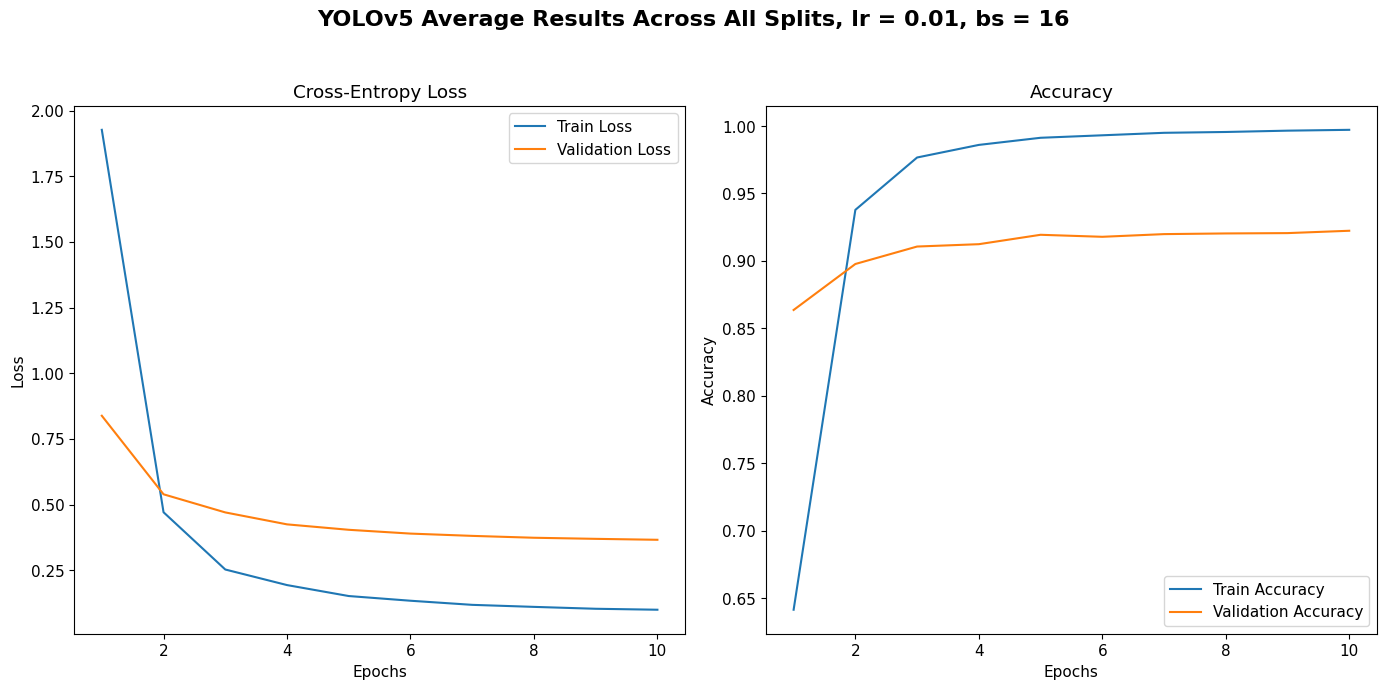

train losses: [     1.9269       0.471     0.25304     0.19376     0.15203     0.13415     0.11849     0.11077     0.10356    0.099915], val losses: [     0.8384     0.53935     0.47038     0.42489     0.40422     0.38975     0.38106     0.37392     0.36976     0.36617], train acc: [     0.6414     0.93784     0.97666       0.986     0.99128     0.99312     0.99496     0.99558     0.99656     0.99717], val acc: [    0.86361     0.89771     0.91065     0.91239     0.91936     0.91787     0.91986     0.92036     0.92061     0.92235]

Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3231, Train Acc: 0.5693, Val Loss: 1.1276, Val Acc: 0.8278, Test Loss: 1.1124, Test Acc: 0.8256
Epoch [2/10]
Train Loss: 0.6752, Train Acc: 0.9182, Val Loss: 0.7079, Val Acc: 0.8780, Test Loss: 0.6936, Test Acc: 0.8801
Epoch [3/10]
Train Loss: 0.3879, Train Acc: 0.9617, Val Loss: 0.6088, Val Acc: 0.8870, Test Loss: 0.5901, Test Acc: 0.8915
Epoch [4/10]
Train Loss: 0.3072, Train Acc: 0.9754, Val Loss: 0.5391, Val Acc: 0.8990, Test Loss: 0.5196, Test Acc: 0.9043
Epoch [5/10]
Train Loss: 0.2493, Train Acc: 0.9845, Val Loss: 0.5144, Val Acc: 0.9019, Test Loss: 0.4943, Test Acc: 0.9085
Epoch [6/10]
Train Loss: 0.2234, Train Acc: 0.9845, Val Loss: 0.4930, Val Acc: 0.9069, Test Loss: 0.4736, Test Acc: 0.9118
Epoch [7/10]
Train Loss: 0.2023, Train Acc: 0.9875, Val Loss: 0.4836, Val Acc: 0.9064, Test Loss: 0.4636, Test Acc: 0.9100
Epoch [8/10]
Train Loss: 0.1916, Train Acc: 0.9894, Val Loss: 0.4729, Val Acc: 0.9114, Test Loss: 0.4521, Test Acc: 0.9142
Epoch [9/10]
Tra

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 2.3472, Train Acc: 0.5572, Val Loss: 1.0936, Val Acc: 0.8367, Test Loss: 1.1205, Test Acc: 0.8204
Epoch [2/10]
Train Loss: 0.6882, Train Acc: 0.9138, Val Loss: 0.6616, Val Acc: 0.8970, Test Loss: 0.6817, Test Acc: 0.8853
Epoch [3/10]
Train Loss: 0.4031, Train Acc: 0.9631, Val Loss: 0.5585, Val Acc: 0.9124, Test Loss: 0.5792, Test Acc: 0.9062
Epoch [4/10]
Train Loss: 0.3171, Train Acc: 0.9705, Val Loss: 0.5013, Val Acc: 0.9134, Test Loss: 0.5170, Test Acc: 0.9100
Epoch [5/10]
Train Loss: 0.2580, Train Acc: 0.9821, Val Loss: 0.4743, Val Acc: 0.9174, Test Loss: 0.4902, Test Acc: 0.9156
Epoch [6/10]
Train Loss: 0.2329, Train Acc: 0.9835, Val Loss: 0.4518, Val Acc: 0.9189, Test Loss: 0.4681, Test Acc: 0.9175
Epoch [7/10]
Train Loss: 0.2109, Train Acc: 0.9865, Val Loss: 0.4416, Val Acc: 0.9209, Test Loss: 0.4565, Test Acc: 0.9166
Epoch [8/10]
Train Loss: 0.2000, Train Acc: 0.9880, Val Loss: 0.4325, Val Acc: 0.9204, Test Loss: 0.4473, Test Acc: 0.9161
Epoch [9/10]
Tra

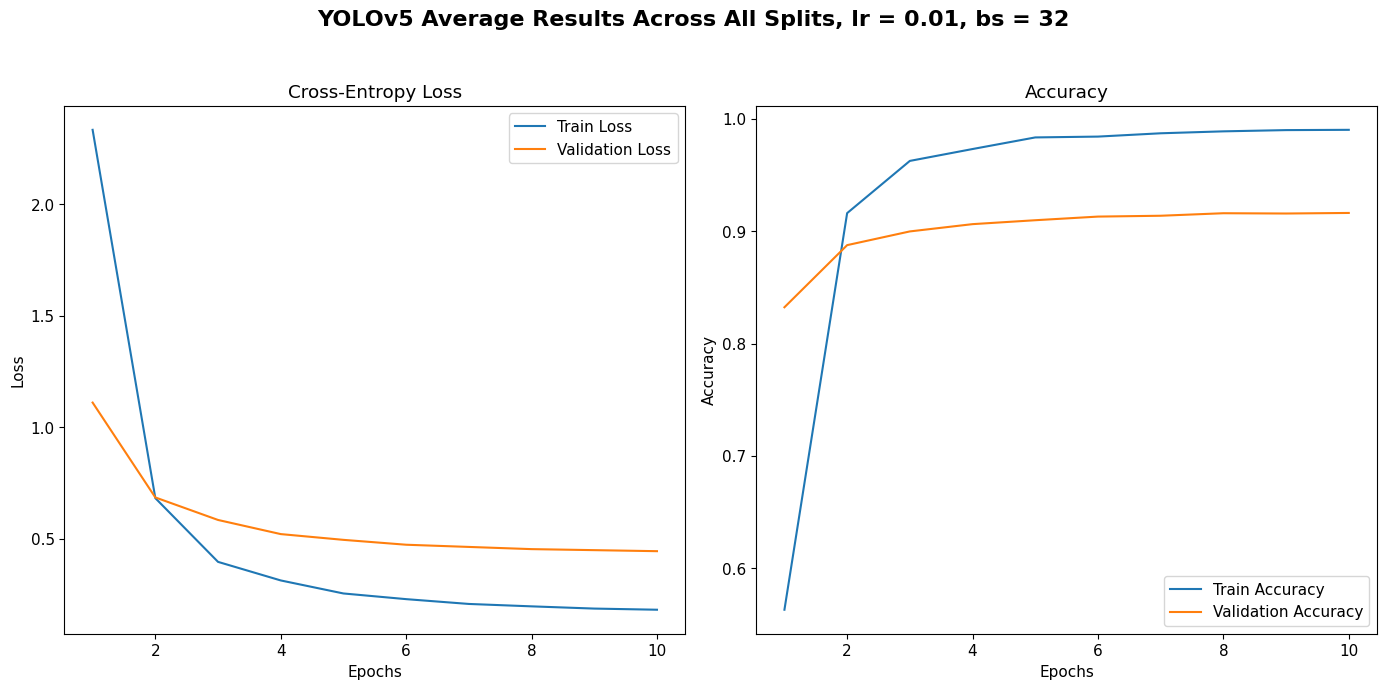

train losses: [     2.3351     0.68168     0.39547     0.31212     0.25364     0.22817     0.20658     0.19578     0.18579     0.18064], val losses: [     1.1106     0.68479     0.58365      0.5202     0.49433     0.47244     0.46258      0.4527     0.44814     0.44349], train acc: [    0.56327     0.91597     0.96241     0.97297     0.98329     0.98403     0.98698      0.9887      0.9898     0.99005], val acc: [    0.83225     0.88751      0.8997     0.90617     0.90966     0.91289     0.91364     0.91588     0.91563     0.91613]


In [ ]:
import numpy as np
%matplotlib inline

# Parameters
split_base_dir = 'flowers_data/split_with_seed'
splits = os.listdir(split_base_dir)
model_path = "yolov5/yolov5s-cls.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate_set = [0.0001, 0.001,0.01]
batch_size_set = [16, 32]

for lr in learning_rate_set:
    for bs in batch_size_set:
        print(f"\nLearning rate: {lr}, Batch size: {bs}")
        # Storage for all splits
        all_train_losses = []
        all_val_losses = []
        all_train_accuracies = []
        all_val_accuracies = []
        all_test_losses = []
        all_test_accuracies = []

        # Iterate over dataset splits
        for i, split_name in enumerate(splits):
            print(f"\nProcessing {i  + 1}...")
            split_dir = os.path.join(split_base_dir, split_name)

            # Create DataLoaders for this split
            train_loader, val_loader, test_loader, num_classes = create_dataloaders_for_split(split_dir, batch_size=bs)

            # Create and train the YOLOv5 model
            yolo5_model = load_and_modify_yolov5(model_path, num_classes, device)
            train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
                yolo5_model, train_loader, val_loader, test_loader, device, num_epochs, learning_rate, use_scheduler=True
            )

            # Store results
            all_train_losses.append(train_losses)
            all_val_losses.append(val_losses)
            all_train_accuracies.append(train_accuracies)
            all_val_accuracies.append(val_accuracies)
            all_test_losses.append(test_loss)
            all_test_accuracies.append(test_accuracy)

        # Calculate average results across splits
        average_train_losses = np.mean(all_train_losses, axis=0)
        average_val_losses = np.mean(all_val_losses, axis=0)
        average_train_accuracies = np.mean(all_train_accuracies, axis=0)
        average_val_accuracies = np.mean(all_val_accuracies, axis=0)
        average_test_loss = np.mean(all_test_losses, axis=0)
        average_test_accuracy = np.mean(all_test_accuracies, axis=0)

        # Plot average results
        plot_results({
            'train_losses': average_train_losses,
            'val_losses': average_val_losses,
            'test_loss': average_test_loss,
            'train_accuracies': average_train_accuracies,
            'val_accuracies': average_val_accuracies,
            'test_accuracy': average_test_accuracy
        }, title="YOLOv5 Average Results Across All Splits, lr = " + str(lr) + ", bs = " + str(bs), without_test=True)

        print("train losses: " + str(average_train_losses) + ", val losses: " + str(average_val_losses) + ", train acc: " + str(average_train_accuracies) + ", val acc: " + str(average_val_accuracies))

#### Run train


Processing 1...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9270, Train Acc: 0.6410, Val Loss: 0.8693, Val Acc: 0.8482, Test Loss: 0.8443, Test Acc: 0.8611
Epoch [2/10]
Train Loss: 0.4667, Train Acc: 0.9376, Val Loss: 0.5706, Val Acc: 0.8870, Test Loss: 0.5485, Test Acc: 0.8915
Epoch [3/10]
Train Loss: 0.2488, Train Acc: 0.9789, Val Loss: 0.4845, Val Acc: 0.9064, Test Loss: 0.4622, Test Acc: 0.9095
Epoch [4/10]
Train Loss: 0.1894, Train Acc: 0.9855, Val Loss: 0.4423, Val Acc: 0.9094, Test Loss: 0.4186, Test Acc: 0.9133
Epoch [5/10]
Train Loss: 0.1479, Train Acc: 0.9931, Val Loss: 0.4218, Val Acc: 0.9149, Test Loss: 0.3984, Test Acc: 0.9175
Epoch [6/10]
Train Loss: 0.1306, Train Acc: 0.9948, Val Loss: 0.4067, Val Acc: 0.9139, Test Loss: 0.3827, Test Acc: 0.9204
Epoch [7/10]
Train Loss: 0.1151, Train Acc: 0.9963, Val Loss: 0.3987, Val Acc: 0.9154, Test Loss: 0.3748, Test Acc: 0.9232
Epoch [8/10]
Train Loss: 0.1078, Train Acc: 0.9971, Val Loss: 0.3917, Val Acc: 0.9149, Test Loss: 0.3674, Test Acc: 0.9246
Epoch [9/10]
Tra

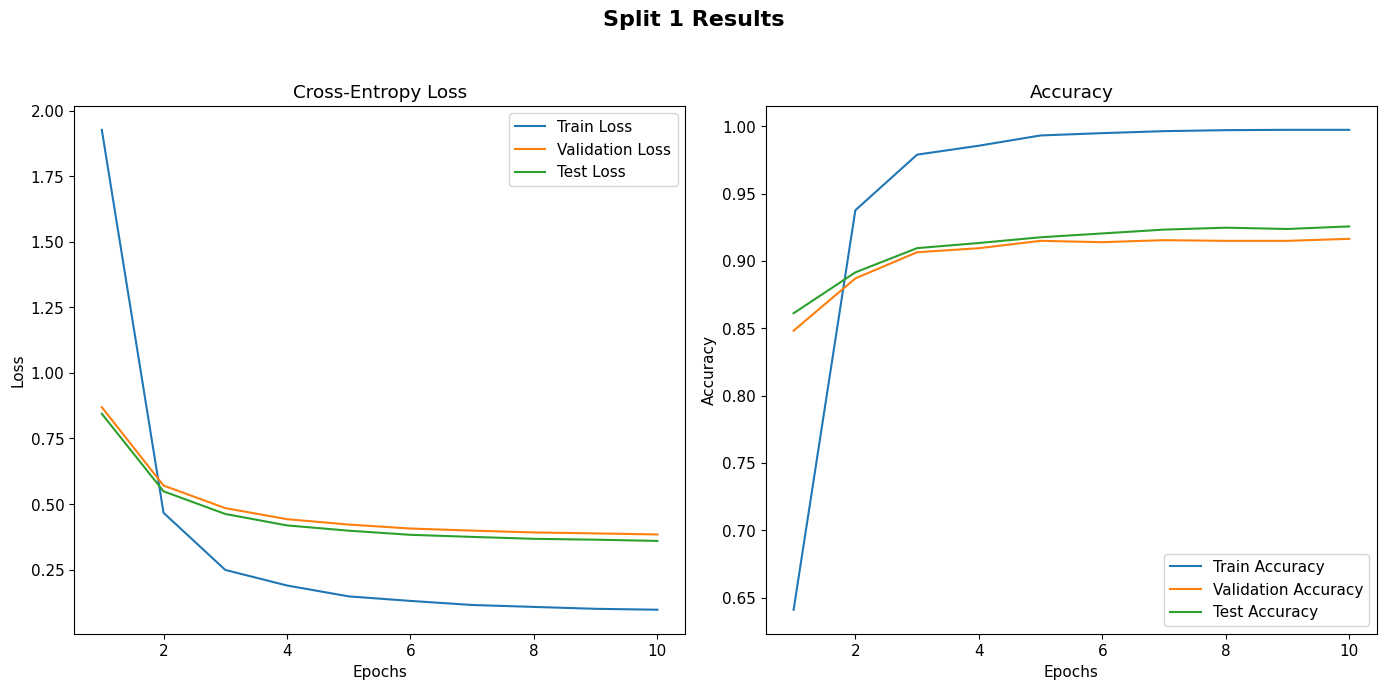


Processing 2...


Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs


Epoch [1/10]
Train Loss: 1.9314, Train Acc: 0.6400, Val Loss: 0.8181, Val Acc: 0.8731, Test Loss: 0.8323, Test Acc: 0.8611
Epoch [2/10]
Train Loss: 0.4759, Train Acc: 0.9344, Val Loss: 0.5319, Val Acc: 0.9000, Test Loss: 0.5432, Test Acc: 0.8967
Epoch [3/10]
Train Loss: 0.2602, Train Acc: 0.9767, Val Loss: 0.4457, Val Acc: 0.9094, Test Loss: 0.4551, Test Acc: 0.9180
Epoch [4/10]
Train Loss: 0.1995, Train Acc: 0.9853, Val Loss: 0.4069, Val Acc: 0.9214, Test Loss: 0.4166, Test Acc: 0.9175
Epoch [5/10]
Train Loss: 0.1563, Train Acc: 0.9909, Val Loss: 0.3867, Val Acc: 0.9209, Test Loss: 0.3918, Test Acc: 0.9242
Epoch [6/10]
Train Loss: 0.1379, Train Acc: 0.9921, Val Loss: 0.3752, Val Acc: 0.9189, Test Loss: 0.3819, Test Acc: 0.9227
Epoch [7/10]
Train Loss: 0.1220, Train Acc: 0.9943, Val Loss: 0.3644, Val Acc: 0.9214, Test Loss: 0.3715, Test Acc: 0.9237
Epoch [8/10]
Train Loss: 0.1144, Train Acc: 0.9951, Val Loss: 0.3575, Val Acc: 0.9238, Test Loss: 0.3636, Test Acc: 0.9246
Epoch [9/10]
Tra

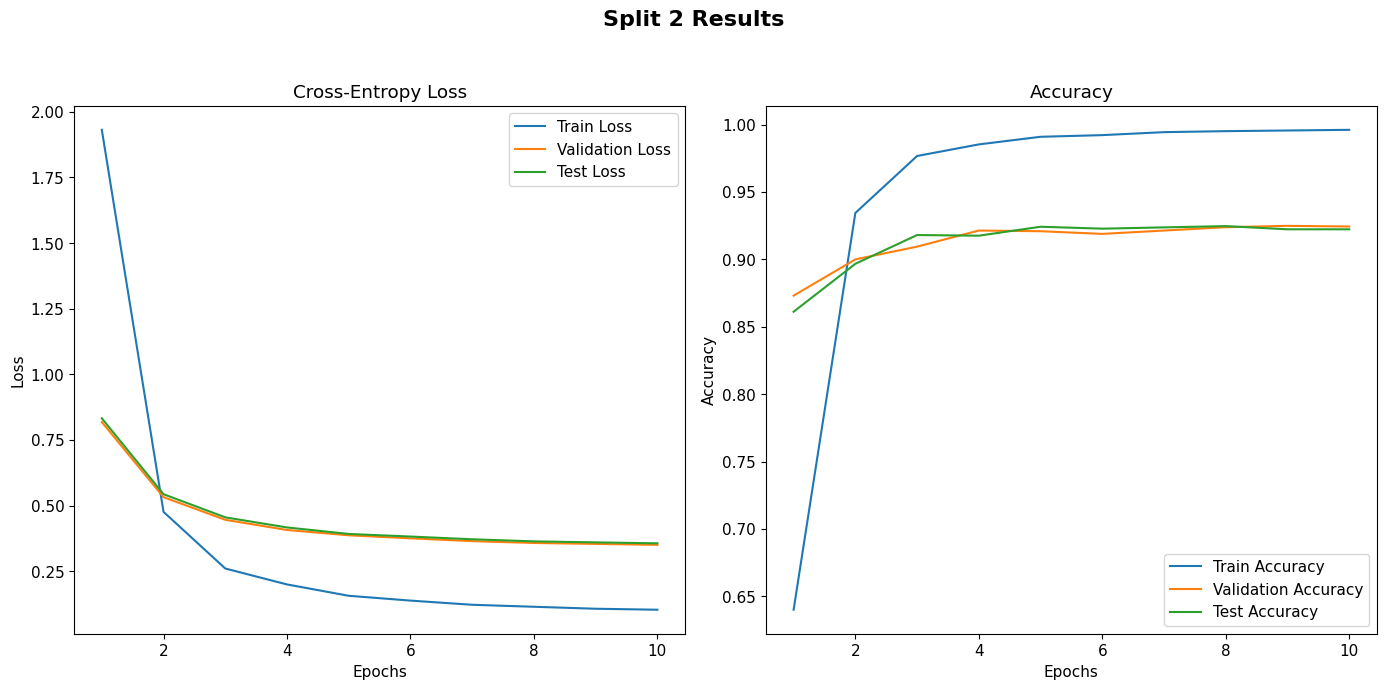

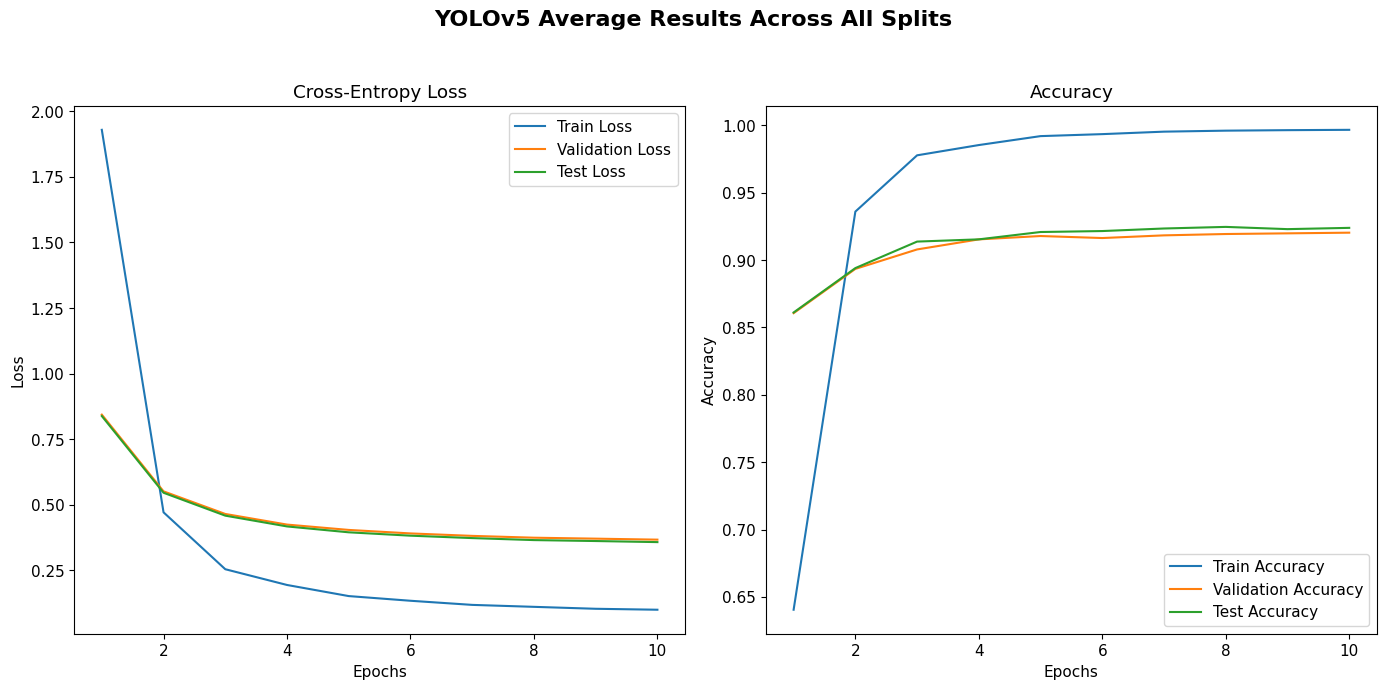

In [ ]:
import numpy as np
%matplotlib inline

# Parameters
split_base_dir = 'flowers_data/split_with_seed'
splits = os.listdir(split_base_dir)
model_path = "yolov5/yolov5s-cls.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
batch_size = 16


# Storage for all splits
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_losses = []
all_test_accuracies = []

# Iterate over dataset splits
for i, split_name in enumerate(splits):
    print(f"\nProcessing {i  + 1}...")
    split_dir = os.path.join(split_base_dir, split_name)

    # Create DataLoaders for this split
    train_loader, val_loader, test_loader, num_classes = create_dataloaders_for_split(split_dir, batch_size)

    # Create and train the YOLOv5 model
    yolo5_model = load_and_modify_yolov5(model_path, num_classes, device)
    train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
        yolo5_model, train_loader, val_loader, test_loader, device, num_epochs, learning_rate, use_scheduler=True
    )

    # Store results
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)

    # Plot training results for the current split
    plot_results({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy
    }, title=f"Split {i + 1} Results")

# Calculate average results across splits
average_train_losses = np.mean(all_train_losses, axis=0)
average_val_losses = np.mean(all_val_losses, axis=0)
average_train_accuracies = np.mean(all_train_accuracies, axis=0)
average_val_accuracies = np.mean(all_val_accuracies, axis=0)
average_test_loss = np.mean(all_test_losses, axis=0)
average_test_accuracy = np.mean(all_test_accuracies, axis=0)

# Plot average results
plot_results({
    'train_losses': average_train_losses,
    'val_losses': average_val_losses,
    'test_loss': average_test_loss,
    'train_accuracies': average_train_accuracies,
    'val_accuracies': average_val_accuracies,
    'test_accuracy': average_test_accuracy
}, title="YOLOv5 Average Results Across All Splits")